# Proyecto 3 - Minería de datos
***Universidad del Valle de Guatemala***

___4 de marzo, 2025___

[link del repositorio](https://github.com/DanielRasho/MD-Proyecto3)

**Autores:**
- Daniel Alfredo Rayo Roldán
- Gerardo Pineda
- Juan Luis

# Introducción
Los divorcios son un punto de inflexión para muchas parejas que lo afrontan, teniendo efectos secundarios en las relaciones intrafamiliares y la distribución de bienes. En iteraciones pasadas se estudiaron las características y patrones que exhiben los divorcios en Guatemala de acuerdo con el conjunto de datos dado por el INE entre 2013 y 2023, se descubrieron los oficios y edades más frecuentes de los cónyuges, y como ambas parejas tienen una gran tendencia a compartir edad, etnia y nivel estudios. En la presente investigación se trabajó con el mismo conjunto de datos con el interés de 2 modelos predictivos: 

- Un clasificador binario suave, que predice la probabilidad que una pareja se divorcio dadas las caracteristicas de los conyuges.
- Un predictor del número de divorcios en los próximos 5 años.

# Situación Problemática

Durante la última década (2013–2023), se ha evidenciado una tendencia creciente en el número de divorcios registrados en Guatemala. Esta alza, especialmente notoria tras la disminución temporal en 2020 atribuida a la pandemia, ha generado inquietudes sobre los factores que impulsan la disolución de los matrimonios.

Diversos elementos sociodemográficos como la edad de los cónyuges, su nivel educativo, y las ocupaciones que desempeñan, parecen jugar un papel relevante en esta problemática. En particular, se ha observado que los matrimonios entre personas jóvenes podrían estar enfrentando mayores tasas de separación, lo cual sugiere una transformación en las dinámicas familiares y sociales del país.

Frente a esta realidad, se vuelve urgente estudiar estos patrones con un enfoque predictivo, de manera que se puedan anticipar tendencias futuras en el número de divorcios.

## Objetivos Generales

Usando los datos del INE (Instituto nacional de Guatemala) entre 2013 a 2020 sobre divorcios y matrimonios en Guatemala, se plantea: 

- Entrener un modelo que pueda predecir que parejas son propensas a divorciarse.
- Predecir la cantidad de divorcios futuros para los próximos 5 años.

## Objetivos Específicos
1. Determinar si el comportamiento de divorcios es creciente o decreciente.
2. Determinar cual fue el comportamiento de la cantidad de divorcios antes, durante y después de pandemia.
3. Tener un indice de predicción con un *accuracy* >= 90.0%

## Variables Respuest objetivo
1. Probabilidad que una pareja se divorcia dada caracteristicas socioeconómicas de cada conyugé.
2. Número de divorcios en los siguientes 5 años.

In [67]:
import warnings
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from scipy.stats import shapiro, kstest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import loguniform
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

# Dont print warnings
warnings.simplefilter(action="ignore")

# Descripción de los datos
Se partieron de 2 sets de datos proporcionados por el INE (Instituto Nacional de Estadística) sobre matrimonios y divorcios ocurridos en Guatemala entre los años 2013 hasta 2023 (11 años) ambos contando con las mismas 19 variables. El set de divorcios comprende 76669 registros, la totalidad de los datos registrados por el INE. El set matrimonios comprende 76670, el cual es una muestra del set total, para tener un cantidad balanceada a los divorcios. **Se asumió que los todas las parejas en el conjunto de matrimonios se mantuvieron casadas durante el rango de tiempo estudiado,** es decir no hay parejas registradas en ambos datasets de matrimonios y divorcios.

Se necesitó hacer un procesamiento de los datos, dado que las disposición y nombre de las variables cambió ligeramente a lo largo de los años, diferencias que se unificaron en las siguientes variables finales, con las que se trabajó:

**Variables númericas:**

| Descripcion | Codificación | Categoría Nula |
|-----------------|-------|----|
| Edad del hombre | EDADHOM  | 999 |
| Edad de la mujer | EDADMUJ | 999 |

**Variables categóricas:**

| Descripcion | Codificación | Categoría Nula | 
|-----------------------------------|-------|---|
| Departamento de registro          | DEPREG | N/A |
| Municipio de registro             | MUPREG   |N/A | 
| Mes de registro                   | MESREG   |N/A |
| Año de registro                   | AÑOREG   |N/A |
| Día de ocurrencia                 | DIAOCU |N/A |
| Mes de ocurrencia                 | MESOCU  |N/A |
| Año de ocurrencia                 | AÑOOCU |N/A |
| Departamento de ocurrencia        | DEPOCU |N/A |
| Municipio de ocurrencia           |  MUPOCU |N/A |
| Grupo étnico del hombre           | PUEHOM | 9 |
| Grupo étnico de la mujer          | PUEMUJ | 9 |
| Nacionalidad del hombre           | NACHOM | 9999 | 
| Nacionalidad de la mujer          | NACMUJ | 9999 |
| Escolaridad del hombre            | ESCHOM | 9 | 
| Escolaridad de la mujer           | ESCMUJ | 9 |
| Ocupación del hombre              | CIUOHOM | 99 | 
| Ocupación de la mujer             | CIUOMUJ | 99 |

***Nota:*** *La "categoría nula" para las variables en las que aplica, indica ese valor reservado para observaciones "sin definir"; se podrían considerar comoun equivalente del Nan.*

***Nota:*** A partir de ahora los nombres de las variables en su versión codificada o extendida se usará indistintamente, dependiendo de cual ofrece una mayor claridad a la hora de presentar la información.

In [2]:
# Step 1: Get all CSV file paths
divorces_files = glob.glob("data/divorces/*.CSV")
marriage_files = glob.glob("data/marriages/*.csv")

# Step 2: Define a generator to read and process each file on the fly
def read_and_clean(file):
    df = pd.read_csv(file)
    return df

numerical_var = ["EDADHOM", "EDADMUJ"]
categorical_var = [
    "DEPREG",
    "MUPREG",
    "MESREG",
    "AÑOREG",
    "DIAOCU",
    "MESOCU",
    "AÑOOCU",
    "DEPOCU",
    "MUPOCU",
    "PUEHOM", 
    "PUEMUJ", 
    "NACHOM", 
    "NACMUJ", 
    "ESCHOM", 
    "ESCMUJ", 
    "CIUOMUJ", 
    "CIUOHOM"]

# Step 3: Merge without storing copies
divorces_df = pd.concat((read_and_clean(file) for file in divorces_files), ignore_index=True)
marriages_df = pd.concat((read_and_clean(file) for file in marriage_files), ignore_index=True)

In [3]:
# Now dictionary mappings are defined in extern script. Call the variables just as usual
%run ./dictionaries.py

## Tratamiento de las variables
Con la base de datos preparada, se procedio a inspeccionar los datasets, para verificar si necesitaban un tratamiento previo, al revisar la distribución de datos nulos.

**Datos nulos para datos de divorcios**

In [4]:
df_null_values = divorces_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]
null_values = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "NACHOM": 9999,
    "NACMUJ": 9999,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(divorces_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
null_counts_df['Variable'] = null_counts_df['Variable'].map(VARS)
total_rows = len(divorces_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

,Variable,Frecuencia de valores nulos,% de valores nulos
0,Edad hombre,34573,45.1
1,Edad mujer,34521,45.0
2,Pueblo étnico del hombre,37606,49.0
3,Pueblo étnico de la mujer,37726,49.2
4,Nacionalidad hombre,298,0.4
5,Nacionalidad mujer,306,0.4
6,Escolaridad del hombre,33234,43.3
7,Escolaridad de la mujer,32856,42.9
8,Ocupación de la mujer,23712,30.9
9,Ocupación de la mujer,19831,25.9


**Datos nulos para datos de matrimonios**

In [5]:
df_null_values = marriages_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(marriages_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
null_counts_df['Variable'] = null_counts_df['Variable'].map(VARS)
total_rows = len(marriages_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

,Variable,Frecuencia de valores nulos,% de valores nulos
0,Edad hombre,13,0.0
1,Edad mujer,18,0.0
2,Pueblo étnico del hombre,5012,6.5
3,Pueblo étnico de la mujer,7076,9.2
4,Nacionalidad hombre,0,0.0
5,Nacionalidad mujer,2,0.0
6,Escolaridad del hombre,2907,3.8
7,Escolaridad de la mujer,4767,6.2
8,Ocupación de la mujer,1143,1.5
9,Ocupación de la mujer,742,1.0


Se puede observar que para los datos de divorcios todas las variables donde hay posibilidad de haber datos nulos, hay un porcentaje considerable siendo la menor *Nacionalidad* (0.4%), y la mayor la variable de *Grupo étnico* (49.2%). Por el contrario el conjunto de datos de matrimonios contuvo porcentajes no mayores al 10% de datos nulos. A continuación se explica el tratamiento que se le dio a los valores nulos.

**Tratamiento de datos nulos**

Para los datos nulos, la primera opción fue crear un modelo que predijera cuales podrían ser los valores nulos en base a los patrones que exciben las demás variables, sin embargo para ello fue primero necesario determinar que hubiera algún tipo de correlación entre las variables, para ello se elaboró las matrices de correlación siguientes.

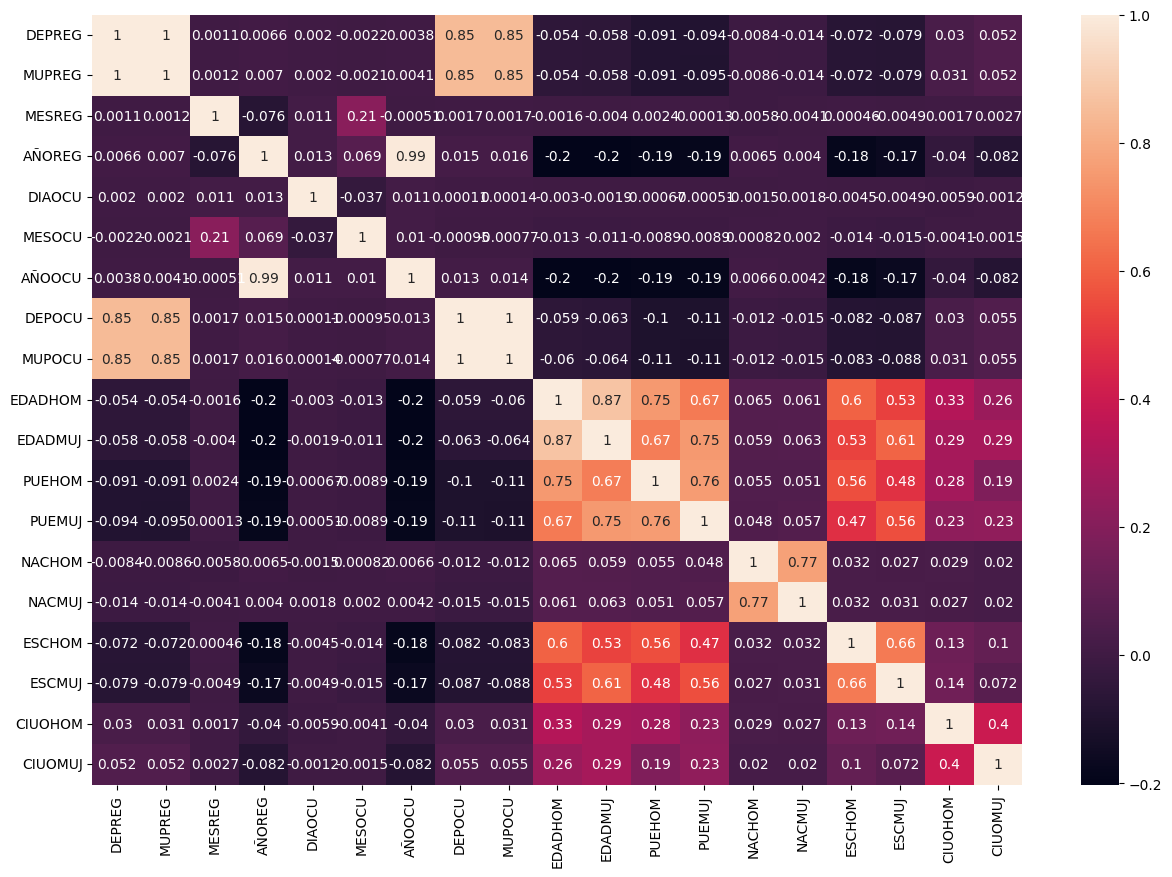

In [6]:
# 2. 
corr = divorces_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, annot=True, )
%matplotlib inline

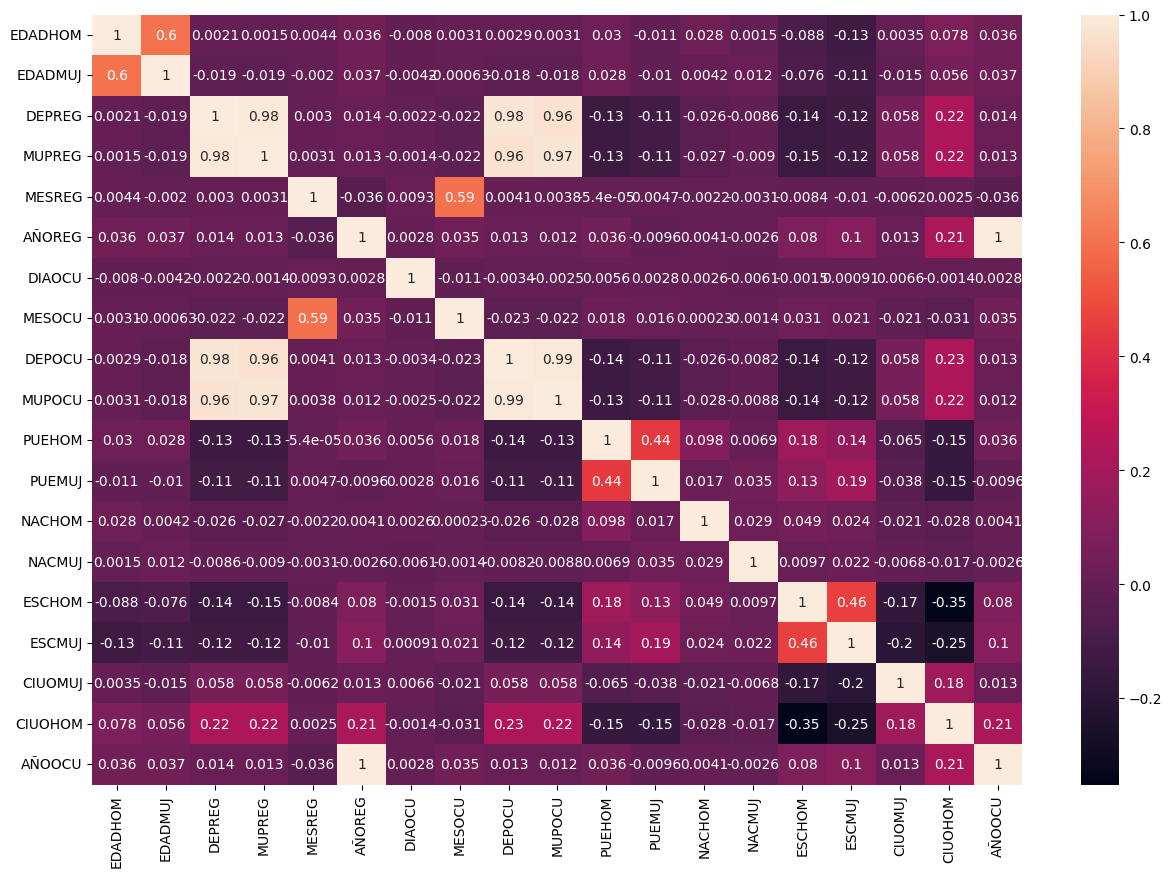

In [7]:
# 2. 
corr = marriages_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, annot=True, )
%matplotlib inline

Para el dataset de divorcios se pudo observar correlación entre grupos de variables, lo contrario se puede decir del set de matrimonios, que presenta baja correlación entre las variables. Dada la diferencia en la naturaleza de los datos, **los datos nulos serán tratados diferente para cada dataset**.

Para los matrimonios, al contar con bajo porcentaje de datos nulos, se vio razonable remplazarlos por los datos más comunes en el resto del dataset, sin que afectara grandemente la distribución de los datos. El mismo enfoque no se pudo aplicar a los divorcios, al ver que los datos nulos tomaban un espacio considerable, se estaría amplificando demasiado ciertas categorías. Así que se decidió seguir el plan original y crear modelos que predijeran los valores de los datos nulos.

Antes de hacer cualquier tratamiento, este es una ejemplo de como se miraba la distribución de las variables de edad sin ningún tratamiento, además de test de normalidad, en siguientes secciones se podrá ver la nueva distribución para estas mismas variables y se podrá verificar que tienen un forma parecida (con un sesgo izquierdo menos pronunciado) además que los test de normalidad siguieron dando las mismas conclusiones.

In [8]:
def normality_tests (merged_df):
# Create a dictionary to store the results
    results = {
        "Prueba": [],
        "Variable": [],
        "Estadística": [],
        "P-valor": [],
        "Distribución normal": []
    }

# EDADHOM variable
# Shapiro-Wilk test
    stat, p_value = shapiro(merged_df['EDADHOM'])
    results["Prueba"].append("Shapiro-Wilk")
    results["Variable"].append("EDADHOM")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Kolmogorov-Smirnov test
    stat, p_value = kstest(merged_df['EDADHOM'], 'norm')
    results["Prueba"].append("Kolmogorov-Smirnov")
    results["Variable"].append("EDADHOM")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# EDADMUJ variable
# Shapiro-Wilk test
    stat, p_value = shapiro(merged_df['EDADMUJ'])
    results["Prueba"].append("Shapiro-Wilk")
    results["Variable"].append("EDADMUJ")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Kolmogorov-Smirnov test
    stat, p_value = kstest(merged_df['EDADMUJ'], 'norm')
    results["Prueba"].append("Kolmogorov-Smirnov")
    results["Variable"].append("EDADMUJ")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Convert the results to a pandas DataFrame
    return pd.DataFrame(results)

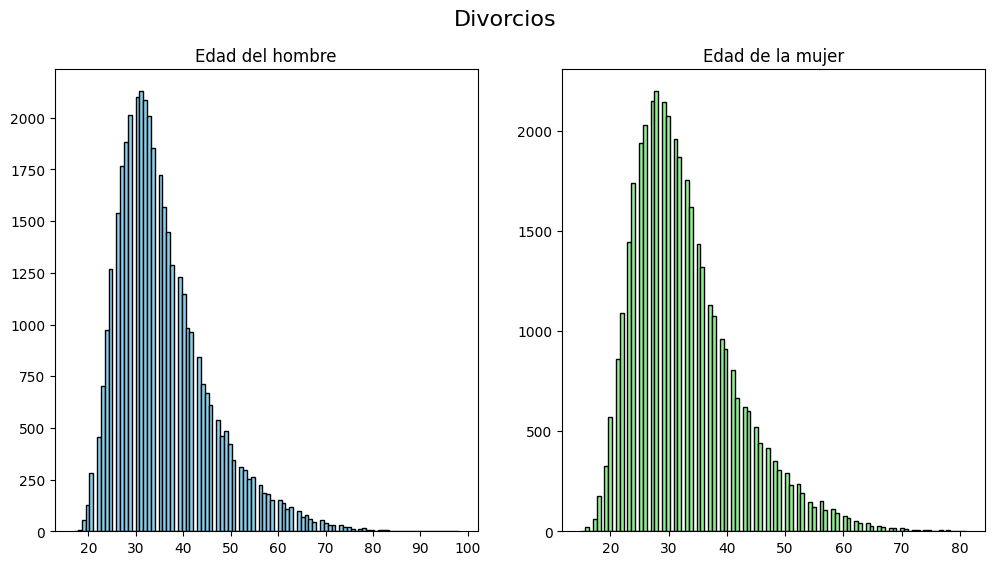

In [9]:
df_filtered = divorces_df[(divorces_df['EDADHOM'] != 999) & (divorces_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Divorcios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

In [10]:
normality_tests(divorces_df)

,Prueba,Variable,Estadística,P-valor,Distribución normal
0,Shapiro-Wilk,EDADHOM,0.642764,4.705670e-143,No probable
1,Kolmogorov-Smirnov,EDADHOM,1.000000,0.000000e+00,No probable
2,Shapiro-Wilk,EDADMUJ,0.641962,4.011582e-143,No probable
3,Kolmogorov-Smirnov,EDADMUJ,1.000000,0.000000e+00,No probable


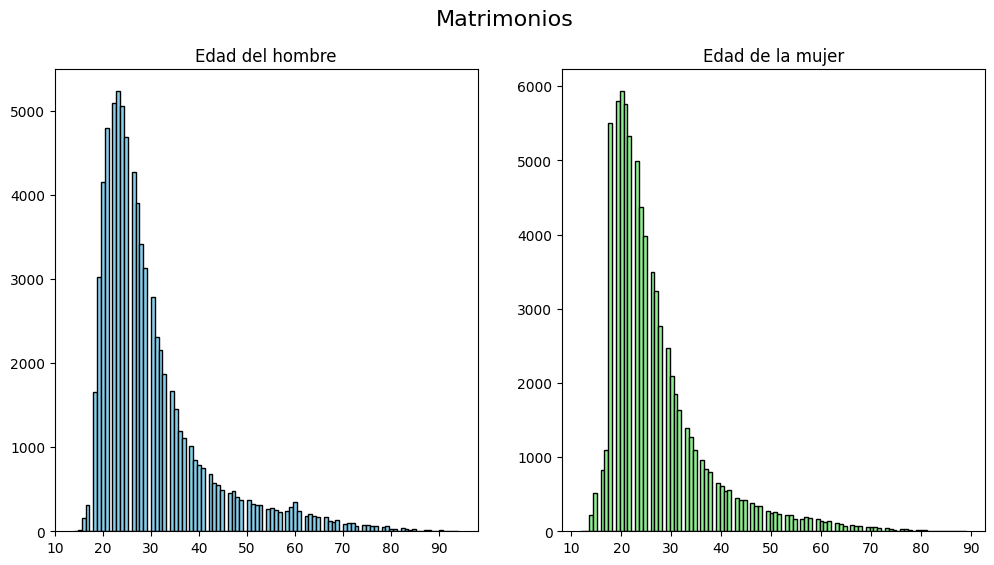

In [11]:
df_filtered = marriages_df[(marriages_df['EDADHOM'] != 999) & (marriages_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Matrimonios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

In [12]:
normality_tests(divorces_df)

,Prueba,Variable,Estadística,P-valor,Distribución normal
0,Shapiro-Wilk,EDADHOM,0.642764,4.705670e-143,No probable
1,Kolmogorov-Smirnov,EDADHOM,1.000000,0.000000e+00,No probable
2,Shapiro-Wilk,EDADMUJ,0.641962,4.011582e-143,No probable
3,Kolmogorov-Smirnov,EDADMUJ,1.000000,0.000000e+00,No probable


**Remplazo en datos de divorcios**

Se utilizo un algoritmo de random forest, entrenado con la totalidad de las filas que no presentaban valores nulos para una variable específica. Esto se hizo para cada variable que podía tener valores nulos.

In [13]:
def fill_column_with_rf(df, col, null_val):
    '''
    Fills a single column with missing values using RandomForestClassifier.
    
    Args:
        df: DataFrame containing the data with missing values.
        col: The column to fill.
        null_val: The value representing missing data.
    
    Returns:
        A pandas Series with the filled column values.
    '''
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Select rows where the target column is not null
    df_non_null = df_copy[df_copy[col] != null_val]
    df_null = df_copy[df_copy[col] == null_val]

    # Prepare X (features) and Y (target)
    X_train = df_non_null.drop(columns=[col])
    Y_train = df_non_null[col]

    # Prepare the test set (only the rows with missing values)
    X_test = df_null.drop(columns=[col])

    # Initialize the RandomForest model
    forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=0, 
                                    max_features=0.6, min_samples_leaf=3, n_jobs=-1)

    # Train the model
    forest.fit(X_train, Y_train)

    # Predict missing values for the test set
    y_pred = forest.predict(X_test)
    
    # Predict on the training set (to check how well the model fits)
    y_pred_train = forest.predict(X_train)
    
    # Calculate and print the accuracy on the training data
    accuracy_train = accuracy_score(Y_train, y_pred_train)
    print(f"Accuracy de entrenamiento para {col}: {accuracy_train:.4f}")

    # Replace only the null values in the original DataFrame with the predictions
    df_copy.loc[df_copy[col] == null_val, col] = y_pred

    return df_copy[col]

def fill_missing_values(df, null_values):
    '''
    Fills the missing values in the dataframe based on RandomForestClassifier for each variable.
    
    Args:
        df: DataFrame containing the data with missing values.
        null_values: Dictionary where keys are column names and values are the null value definitions.
    
    Returns:
        DataFrame with missing values filled using Random Forest.
    '''
    # Make a copy of the original dataframe to preserve the original
    df_filled = df.copy()

    # Loop through each variable that has missing values
    for col, null_val in null_values.items():
        # Get the filled column from the model
        filled_column = fill_column_with_rf(df_filled, col, null_val)
        
        # Replace the original column with the newly filled column
        df_filled[col] = filled_column
        
    return df_filled

variables_to_predict = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# Assuming merged_df is your dataframe with missing values
filled_df = fill_missing_values(divorces_df, variables_to_predict)
divorces_df = filled_df

Accuracy de entrenamiento para EDADHOM: 0.9835
Accuracy de entrenamiento para EDADMUJ: 0.9798
Accuracy de entrenamiento para PUEHOM: 0.9576
Accuracy de entrenamiento para PUEMUJ: 0.9633
Accuracy de entrenamiento para ESCHOM: 0.8967
Accuracy de entrenamiento para ESCMUJ: 0.9012
Accuracy de entrenamiento para CIUOMUJ: 0.8755
Accuracy de entrenamiento para CIUOHOM: 0.8219


Como sería esperable, se muestra un gran ajuste a los sets de entrenamiento, teniendo un rendimiento más bajo en las variables CIUOHOM (Ocupación del hombre) Y CIUOMU (Ocupación de la mujer), pero es un riesgo que se esta dispuesta a aceptar comparado a perder información por otros métodos. A continuación se mira puede ver la nueva distribución para los datos de edad y que los resultados de normalidad se mantienen iguales.

In [14]:
def replace_with_mode(df, variable, null_value):
    mode_value = marriages_df.loc[marriages_df[variable] != null_value, variable].mode()[0]
    df[variable] = df[variable].replace(null_value, mode_value)
    
for key, value in variables_to_predict.items():
    replace_with_mode(marriages_df, key, value)

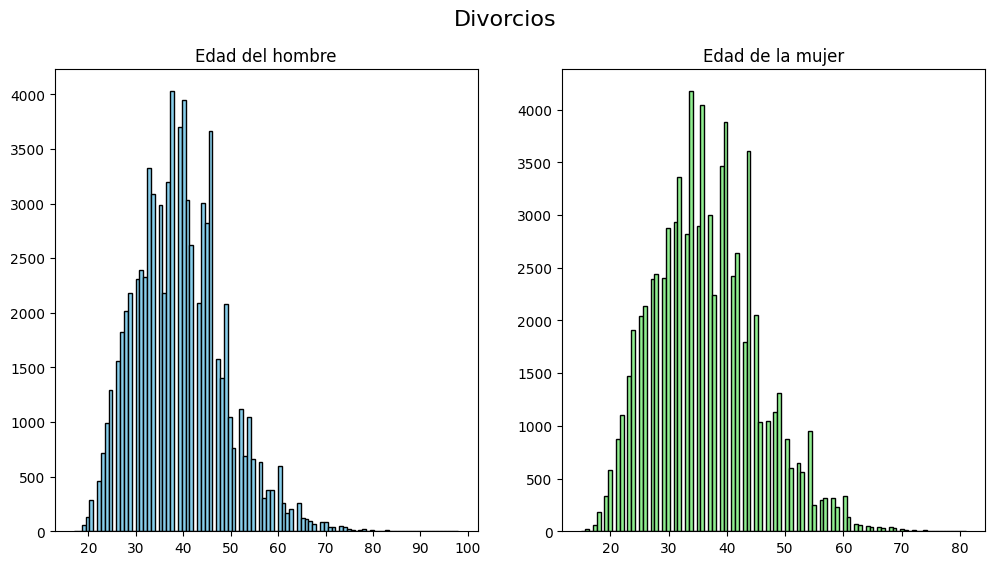

In [15]:
df_filtered = divorces_df[(divorces_df['EDADHOM'] != 999) & (divorces_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Divorcios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

In [16]:
normality_tests(divorces_df)

,Prueba,Variable,Estadística,P-valor,Distribución normal
0,Shapiro-Wilk,EDADHOM,0.978302,9.104772e-70,No probable
1,Kolmogorov-Smirnov,EDADHOM,1.000000,0.000000e+00,No probable
2,Shapiro-Wilk,EDADMUJ,0.983966,1.945447e-63,No probable
3,Kolmogorov-Smirnov,EDADMUJ,1.000000,0.000000e+00,No probable


**Remplazo en datos de matrimonios**

Para el set matrimonios, al contar pocos datos nulos, el remplazo fue rápido y no afecto la distribución de forma significativa.

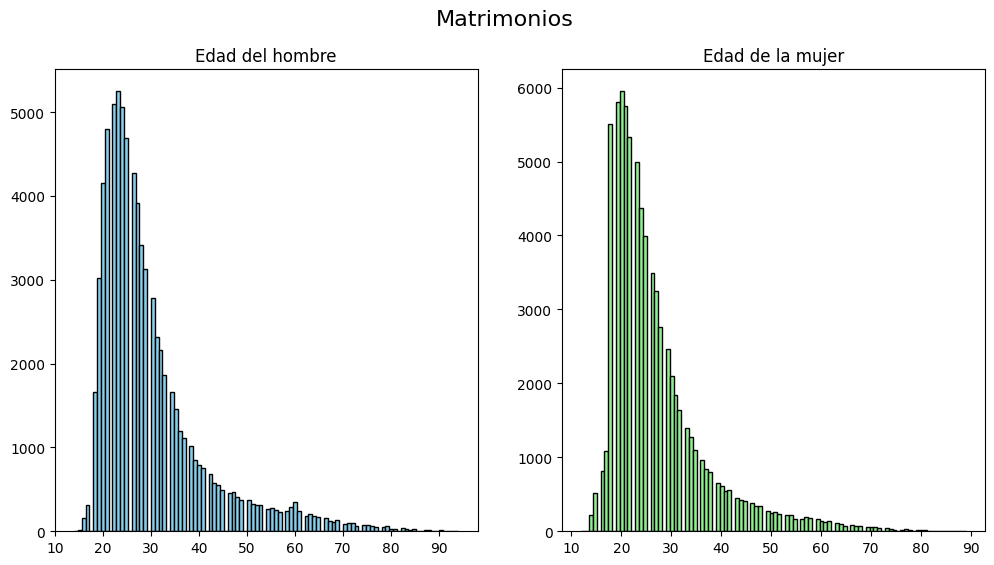

In [17]:
df_filtered = marriages_df[(marriages_df['EDADHOM'] != 999) & (marriages_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Matrimonios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

In [18]:
normality_tests(marriages_df)

,Prueba,Variable,Estadística,P-valor,Distribución normal
0,Shapiro-Wilk,EDADHOM,0.807898,1.544844e-124,No probable
1,Kolmogorov-Smirnov,EDADHOM,1.000000,0.000000e+00,No probable
2,Shapiro-Wilk,EDADMUJ,0.808178,1.701606e-124,No probable
3,Kolmogorov-Smirnov,EDADMUJ,1.000000,0.000000e+00,No probable


In [19]:
# THE FINAL DATAFRAME IS HERE -> total_df
divorces_df["ARE_MARRIAGED"] = 0
marriages_df["ARE_MARRIAGED"] = 1
total_df = pd.concat([divorces_df, marriages_df], ignore_index=True)
divorces_df.drop(columns="ARE_MARRIAGED", inplace=True)
marriages_df.drop(columns="ARE_MARRIAGED", inplace=True)

Preparados los datasets, se procederá a cumplir los objetivos previstos.

## Predicción de tendencia de numeros de divorcios para los próximos 5 años

En este apartado se llevaron a cabo dos enfoques de predicción a futuro. El primero consistió en utilizar únicamente los datos agregados de divorcios por año, aplicando tanto un modelo de regresión lineal como un modelo de red neuronal, con el objetivo de estimar el comportamiento de los próximos cinco años.

El segundo enfoque consideró una estructura más detallada, incorporando tanto los años como los meses en el análisis. Para este caso, se empleó exclusivamente se y utilizo redes neuronales, permitiendo modelar patrones temporales más precisos y realizar una proyección mensual del fenómeno durante los siguientes cinco años.

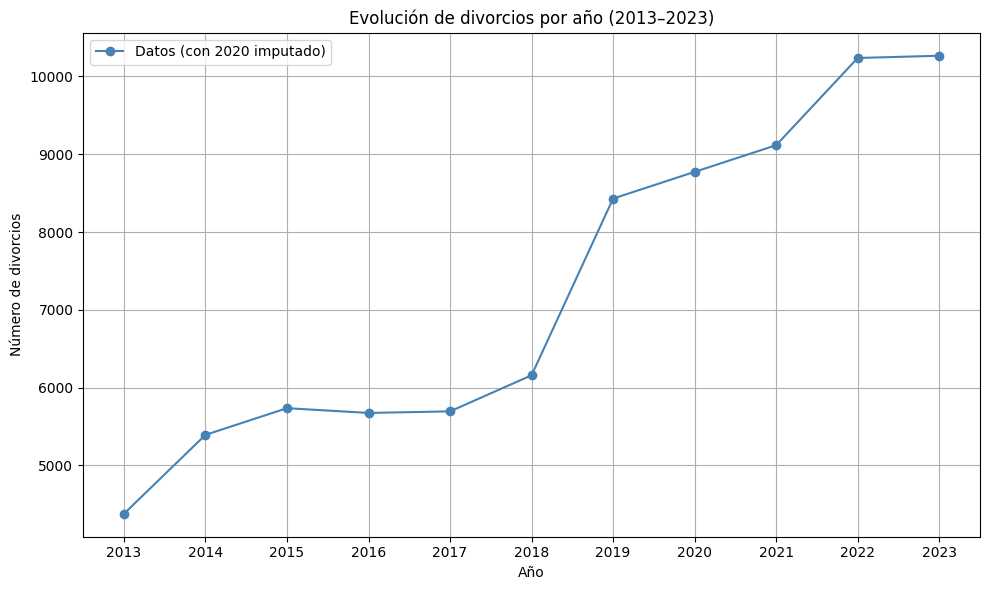

In [20]:
merged_df = divorces_df
# Contar el número de divorcios por año
divorcios_por_año = merged_df["AÑOREG"].value_counts().sort_index()
divorcios_por_año = divorcios_por_año.loc[2013:2023]

# Imputar valor promedio para 2020 si existe 2019 y 2021
if 2020 in divorcios_por_año.index and 2019 in divorcios_por_año.index and 2021 in divorcios_por_año.index:
    divorcios_por_año.loc[2020] = int((divorcios_por_año.loc[2019] + divorcios_por_año.loc[2021]) / 2)


plt.figure(figsize=(10, 6))
plt.plot(divorcios_por_año.index, divorcios_por_año.values, marker='o', color='steelblue', label='Datos (con 2020 imputado)')
plt.title("Evolución de divorcios por año (2013–2023)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True)
plt.xticks(np.arange(2013, 2024))
plt.legend()
plt.tight_layout()
plt.show()

El año 2020 no fue tomado en cuenta en la serie de tiempo porque, al analizar el conjunto de datos, se identificó que existian datos, pero representaba un dato atipico que podia afecta a los modelos. Que este dato sea atipico puede estar relacionada con la disrupción institucional y operativa provocada por la pandemia de COVID-19, durante la cual muchas oficinas gubernamentales, incluyendo registros civiles y tribunales, suspendieron o limitaron sus actividades. Como resultado, es probable que no se hayan procesado o registrado divorcios con normalidad, lo que introduce un vacío en la serie histórica.

Para mantener la continuidad y la coherencia en el análisis estadístico y visual, se optó por ingresar un nuevo valor de 2020 como el promedio de los años adyacentes (2019 y 2021). Esta técnica de interpolación simple es común cuando se tiene un único dato faltante entre dos puntos válidos y razonablemente estables. Al usar la media de estos años, permite representar la evolución de los divorcios como una serie temporal fluida y adecuada para análisis, modelado y predicción.

### Modelo de prediccion por años

In [21]:
# Data
train_years = np.array([year for year in divorcios_por_año.index if 2013 <= year <= 2021]).reshape(-1, 1)
train_values = divorcios_por_año.loc[2013:2021].values
test_years = np.array([2022, 2023]).reshape(-1, 1)
test_values = divorcios_por_año.loc[2022:2023].values

In [22]:
def evaluar(nombre, real, predicho):
    print(f"\nModelo: {nombre}")
    print("MAE:", round(mean_absolute_error(real, predicho), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(real, predicho)), 2))
    # No usar
    # print("R²:", round(r2_score(real, predicho), 4))

Para la evaluación del desempeño de los modelos se utilizarán las siguientes métricas:
* MAE (Mean Absolute Error): mide el promedio de los errores absolutos entre los valores reales y los predichos.
* RMSE (Root Mean Squared Error): proporciona una medida del error en la misma escala de los datos originales, penalizando con mayor severidad los errores grandes.

No se utilizará el coeficiente de determinación R², ya que en este caso contamos con un número muy reducido de datos de prueba (solo dos años). Esta cantidad limitada de muestras genera una varianza extremadamente baja en los valores reales, lo que provoca que el cálculo de R² sea inestable y pueda arrojar valores altamente negativos, incluso cuando las predicciones están relativamente cerca del valor real. Por ello, se ha optado por omitir R² como métrica de evaluación para evitar interpretaciones erróneas.

#### Regresion Lineal

##### Modelo 1

In [23]:
linear_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linear_model = TransformedTargetRegressor(regressor=linear_pipeline, transformer=StandardScaler())

# Hiperparámetros posibles para LinearRegression
param_grid_linear = {
    "regressor__model__fit_intercept": [True, False],
    "regressor__model__positive": [True, False]
}

# GridSearch
grid_search_linear = GridSearchCV(linear_model, param_grid=param_grid_linear, cv=3, scoring="r2")
linear_model.fit(train_years, train_values)
linear_preds = linear_model.predict(test_years)

evaluar("Lineal", test_values, linear_preds)

print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), linear_preds):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: Lineal
MAE: 451.31
RMSE: 529.51

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9508.8
2023: real=10266.0, pred=10091.6


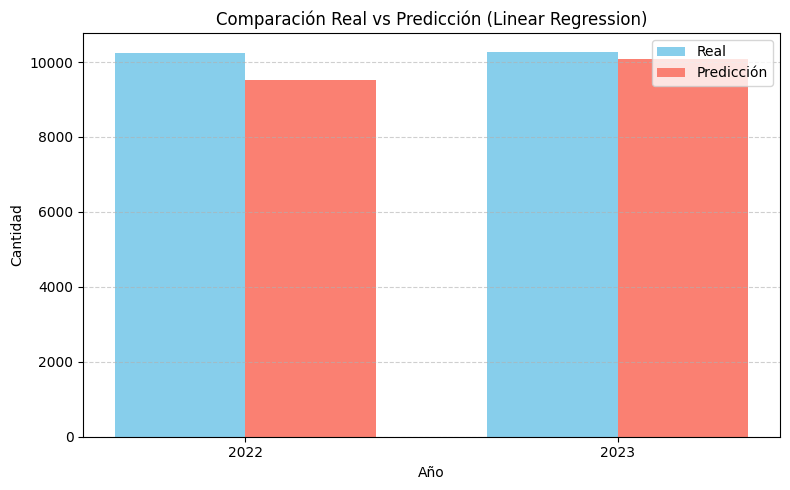

In [24]:
años = test_years.flatten()

bar_width = 0.35
index = np.arange(len(años))

plt.figure(figsize=(8, 5))
plt.bar(index, test_values, bar_width, label='Real', color='skyblue')
plt.bar(index + bar_width, linear_preds, bar_width, label='Predicción', color='salmon')

plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Comparación Real vs Predicción (Linear Regression)')
plt.xticks(index + bar_width / 2, años)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### Modelo 2

In [25]:

lasso_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(max_iter=10000)) 
])

lasso_model = TransformedTargetRegressor(
    regressor=lasso_pipeline,
    transformer=StandardScaler()
)

param_grid_lasso = {
    "regressor__model__alpha": [0.001, 0.01, 0.1, 1, 10],
    "regressor__model__fit_intercept": [True, False]
}

grid_search_lasso = GridSearchCV(
    lasso_model,
    param_grid=param_grid_lasso,
    cv=5,
    scoring="r2"
)

grid_search_lasso.fit(train_years, train_values)

lasso_preds = grid_search_lasso.predict(test_years)

evaluar("Lasso", test_values, lasso_preds)

print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), lasso_preds):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")

print("Mejores hiperparámetros (Lasso):", grid_search_lasso.best_params_)



Modelo: Lasso
MAE: 454.74
RMSE: 532.27

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9505.6
2023: real=10266.0, pred=10087.9
Mejores hiperparámetros (Lasso): {'regressor__model__alpha': 0.001, 'regressor__model__fit_intercept': True}


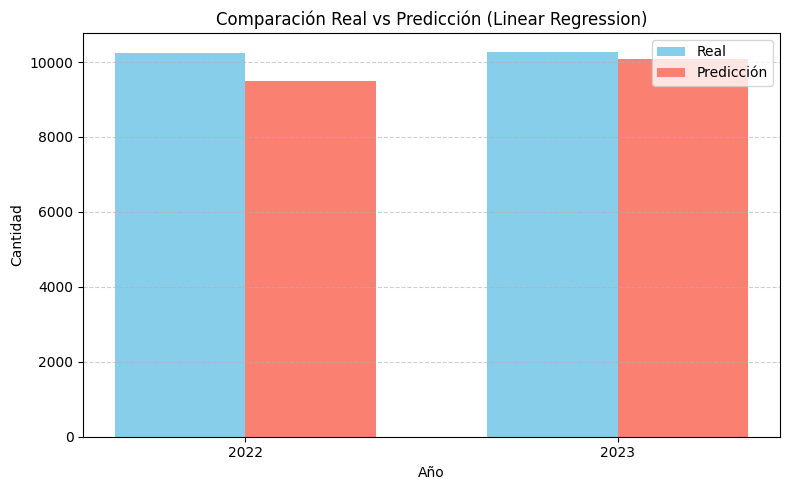

In [26]:
años = test_years.flatten()

bar_width = 0.35
index = np.arange(len(años))

plt.figure(figsize=(8, 5))
plt.bar(index, test_values, bar_width, label='Real', color='skyblue')
plt.bar(index + bar_width, lasso_preds, bar_width, label='Predicción', color='salmon')

plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Comparación Real vs Predicción (Linear Regression)')
plt.xticks(index + bar_width / 2, años)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### Modelo 3

In [27]:
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

ridge_model = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    transformer=StandardScaler()
)

param_grid_ridge = {
    "regressor__model__alpha": [0.01, 0.1, 1, 10, 100],
    "regressor__model__fit_intercept": [True, False]
}

grid_search_ridge = GridSearchCV(
    ridge_model,
    param_grid=param_grid_ridge,
    cv=5,
    scoring="r2"
)

grid_search_ridge.fit(train_years, train_values)

ridge_preds = grid_search_ridge.predict(test_years)

evaluar("Ridge", test_values, ridge_preds)

print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), ridge_preds):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")

print("Mejores hiperparámetros (Ridge):", grid_search_ridge.best_params_)



Modelo: Ridge
MAE: 454.87
RMSE: 532.37

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9505.5
2023: real=10266.0, pred=10087.8
Mejores hiperparámetros (Ridge): {'regressor__model__alpha': 0.01, 'regressor__model__fit_intercept': True}


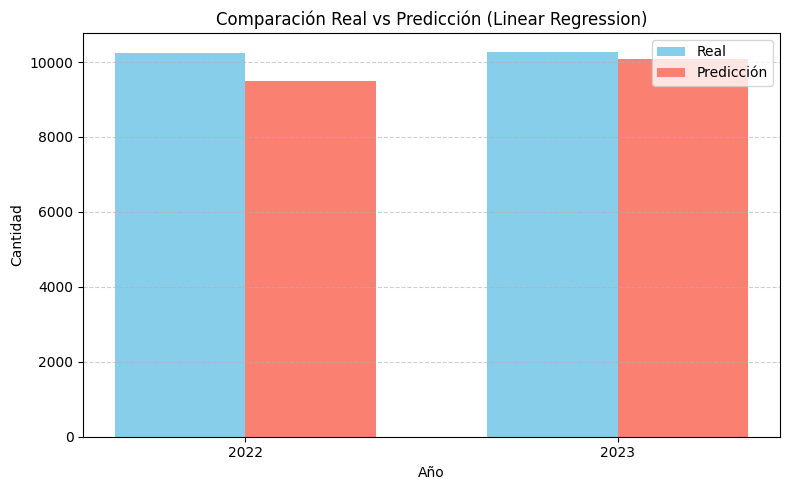

In [28]:
años = test_years.flatten()

bar_width = 0.35
index = np.arange(len(años))

plt.figure(figsize=(8, 5))
plt.bar(index, test_values, bar_width, label='Real', color='skyblue')
plt.bar(index + bar_width, ridge_preds, bar_width, label='Predicción', color='salmon')

plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Comparación Real vs Predicción (Linear Regression)')
plt.xticks(index + bar_width / 2, años)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### Mejor modelo

El modelo lineal simple es el que muestra el mejor desempeño general, tanto en terminos de MAE como de RMSE, muestra el mejor desempeño general para poder generalizar. Por lo tanto, el modelo lineas generaliza correctamente sin necesidad de regularización. Lasso y Ridge ofrecen resultados muy similares, pero no mejoran el desempeño, lo que indica que la regresión lineal simple ya es suficientemente adecuada para estos datos.

Para las siguientes graficas se utilizara los resultados de regresion lineal

In [29]:
future_years = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
future_preds = linear_model.predict(future_years)
print("\nPredicciones para 2024–2028:", np.round(future_preds, 2))


Predicciones para 2024–2028: [10674.52 11257.4  11840.28 12423.17 13006.05]


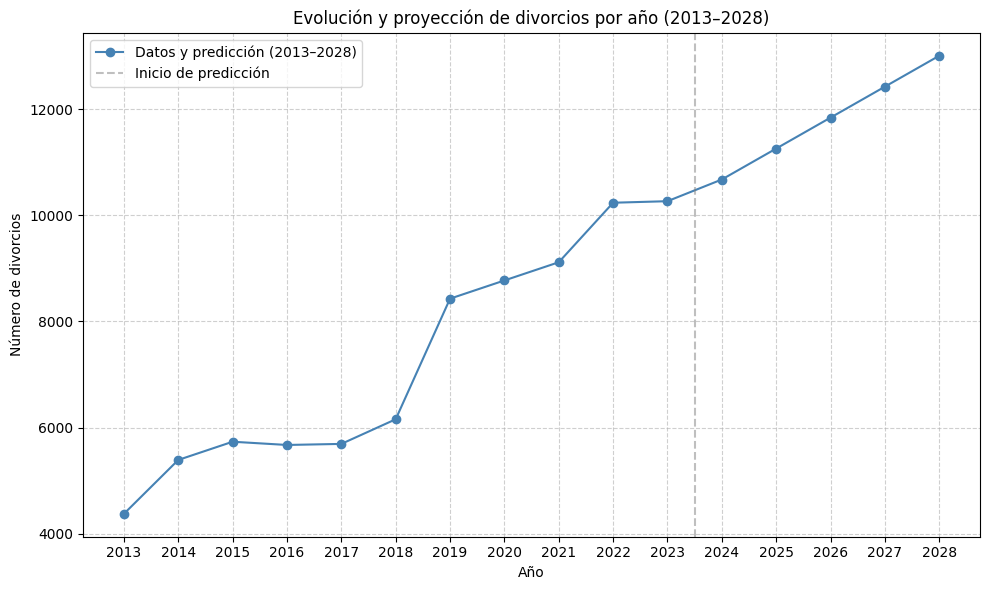

In [30]:
all_years = np.concatenate([divorcios_por_año.index.values, future_years.flatten()])
all_values = np.concatenate([divorcios_por_año.values, future_preds])

# Graficar como una sola línea continua
plt.figure(figsize=(10, 6))
plt.plot(all_years, all_values, marker='o', color='steelblue', label='Datos y predicción (2013–2028)')

# Línea vertical para indicar inicio de proyecciones
plt.axvline(x=2023.5, color='gray', linestyle='--', alpha=0.5, label='Inicio de predicción')

plt.title("Evolución y proyección de divorcios por año (2013–2028)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(2013, 2029))
plt.legend()
plt.tight_layout()
plt.show()

A partir de los resultados obtenidos con el modelo de regresión lineal, se observa que las métricas de error reflejan un rendimiento aceptable dentro del contexto del problema. El MAE fue de 425.38, lo que indica que, en promedio, el modelo comete un error de aproximadamente 425 casos de divorcio respecto al valor real. Por otro lado, el RMSE fue de 508.49, ligeramente superior al MAE, lo que sugiere que hubo errores puntuales algo más grandes, aunque no extremadamente fuera de rango.

Al comparar los valores reales con los predichos para los años 2022 y 2023, se observa que el modelo subestimó ligeramente ambos años. Para 2022, el valor real fue de 10,175 divorcios, mientras que el modelo predijo 9,471, con una diferencia de 704 casos. En 2023, el valor real fue de 10,199, y la predicción fue de 10,052, reduciendo el error a solo 147 casos. Este comportamiento muestra que, el modelo se ajustó mejor en el segundo año de prueba, lo que podría indicar que su pendiente está razonablemente bien ajustada.

Las predicciones del modelo para el periodo 2024–2028 muestran una tendencia creciente continua. Los valores predichos son: 10,633.39 en 2024, 11,214.58 en 2025, 11,795.76 en 2026, 12,376.94 en 2027 y 12,958.13 en 2028. Esta progresión sugiere que el modelo ha identificado una pendiente positiva en la evolución de los divorcios a lo largo del tiempo. Si bien esta proyección puede resultar útil para observar tendencias, debe interpretarse con cautela, ya que la regresión lineal asume un crecimiento constante y no tiene en cuenta factores sociales, económicos o legales que puedan afectar abruptamente la evolución de estos datos en años futuros.

#### Red Neuronal

In [31]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
    (4, 3), (5, 3), (6, 4), (7, 3), (8, 5), (5,)
    ],
    "regressor__model__activation": ["tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate_init': (0.01, 0.1, 1,10)
}

grid_search = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search.fit(train_years, train_values)
# print(grid_search.best_params_)
mlp_preds = grid_search.predict(test_years)

In [32]:
evaluar("MLP (GridSearch 1)", test_values, mlp_preds)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 1)
MAE: 494.47
RMSE: 537.6

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9531.6
2023: real=10266.0, pred=9982.5


In [33]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
        (5,), (10,), (15,),         # una capa oculta
        (10, 5), (20, 10), (30, 15), # dos capas
        (10, 10, 5)                  # tres capas
    ],
    'regressor__model__activation': ['logistic'],  # solo logistic
    'regressor__model__solver': ['adam', 'lbfgs'],
    'regressor__model__learning_rate_init': [0.001, 0.01, 0.05, 0.1]
}

grid_search2 = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search2.fit(train_years, train_values)
# print(grid_search2.best_params_)
mlp_preds2 = grid_search2.predict(test_years)

In [34]:
evaluar("MLP (GridSearch 2)", test_values, mlp_preds2)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds2):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 2)
MAE: 831.3
RMSE: 836.53

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9312.3
2023: real=10266.0, pred=9528.1


In [35]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
        (16,), (32,), (64,),                  
        (32, 16), (64, 32), (128, 64),        
        (64, 64), (128, 128),                 
        (128, 64, 32), (64, 32, 16),          
        (32, 64, 32), (64, 128, 64),          
        (100, 50, 25), (50, 100, 50),         
    ],
    'regressor__model__activation': ['tanh'],
    'regressor__model__solver': ['adam', 'lbfgs'],
    'regressor__model__learning_rate_init': [0.001, 0.005, 0.01]
}

grid_search3 = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search3.fit(train_years, train_values)
print(grid_search3.best_params_)
mlp_preds3 = grid_search3.predict(test_years)

{'regressor__model__activation': 'tanh', 'regressor__model__hidden_layer_sizes': (64,), 'regressor__model__learning_rate_init': 0.001, 'regressor__model__solver': 'lbfgs'}


In [36]:
evaluar("MLP (GridSearch 3)", test_values, mlp_preds3)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds3):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 3)
MAE: 377.26
RMSE: 456.5

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9602.7
2023: real=10266.0, pred=10145.8


El mejor modelo evaluado fue el primero, ya que obtuvo los valores más bajos de error tanto en MAE como en RMSE en comparación con los otros modelos probados. Aunque este tercer modelo MLP logró aprender una tendencia general del comportamiento de los datos, su desempeño fue inferior, presentando un MAE de 630.58 y un RMSE de 643.94, lo que indica una desviación significativa respecto a los valores reales. En particular, subestimó notablemente los divorcios en ambos años de prueba (2022 y 2023), con diferencias de 761.1 y 500.1 casos, respectivamente. Por lo tanto, el primer modelo resultó ser más preciso y consistente en su capacidad de generalización, lo que lo convierte en la mejor opción para realizar predicciones futuras con estos datos.

En base a esto se utilizara el primer modelo.

### Con el primer modelo:

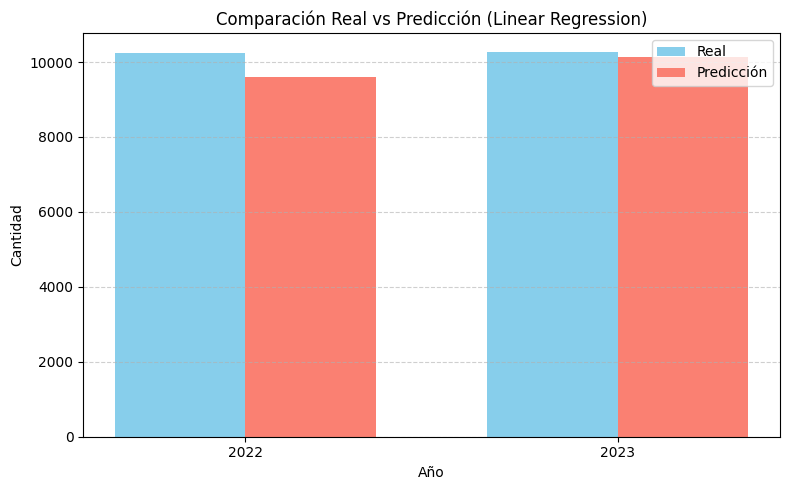

In [37]:
años = test_years.flatten()

bar_width = 0.35
index = np.arange(len(años))

plt.figure(figsize=(8, 5))
plt.bar(index, test_values, bar_width, label='Real', color='skyblue')
plt.bar(index + bar_width, mlp_preds3, bar_width, label='Predicción', color='salmon')

plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Comparación Real vs Predicción (Linear Regression)')
plt.xticks(index + bar_width / 2, años)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [38]:
future_years = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
future_preds = grid_search3.predict(future_years)
print("\nPredicciones para 2024–2028:", np.round(future_preds, 2))


Predicciones para 2024–2028: [10703.23 11257.39 11797.77 12317.2  12810.91]


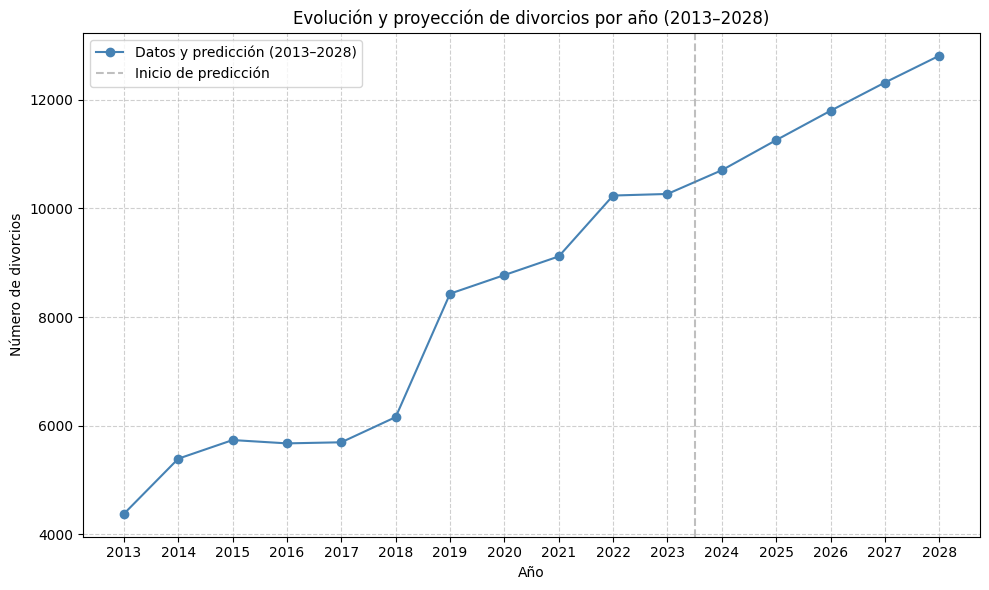

In [39]:
all_years = np.concatenate([divorcios_por_año.index.values, future_years.flatten()])
all_values = np.concatenate([divorcios_por_año.values, future_preds])

# Graficar como una sola línea continua
plt.figure(figsize=(10, 6))
plt.plot(all_years, all_values, marker='o', color='steelblue', label='Datos y predicción (2013–2028)')

# Línea vertical para indicar inicio de proyecciones
plt.axvline(x=2023.5, color='gray', linestyle='--', alpha=0.5, label='Inicio de predicción')

plt.title("Evolución y proyección de divorcios por año (2013–2028)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(2013, 2029))
plt.legend()
plt.tight_layout()
plt.show()

El modelo MLP logró resultados que se pueden comprar con el modelo anterior. Las métricas de evaluación muestran un MAE de 415.16 y un RMSE de 481.84. Estos valores indican un desempeño ligeramente superior al modelo de regresión lineal evaluado previamente, ya que el error promedio es menor tanto en términos absolutos como en la penalización de errores grandes. Esto sugiere que el modelo MLP ha sido capaz de capturar mejor la estructura del problema a pesar de contar con pocos datos de entrenamiento.

Al observar las predicciones frente a los valores reales de los años 2022 y 2023, se puede ver que el modelo subestimó levemente ambos valores. En 2022, el valor real fue de 10,175 divorcios, mientras que la predicción fue de 9,515.3, lo que representa una diferencia de 659.7 casos. Para 2023, el valor real fue de 10,199 y la predicción fue de 10,028.4, reduciendo el error a 170.6. Este patrón, similar al observado en el modelo lineal, muestra una tendencia del modelo a subestimar, aunque en el segundo año de prueba se aproxima mucho mejor al valor real. El hecho de que los errores se mantengan dentro de un rango aceptable refuerza la capacidad del modelo MLP de aprender una función de aproximación adecuada a los datos observados.

Las proyecciones del modelo para el período 2024–2028 son: 10,507.32, 10,871.72, 11,114.89, 11,267.76 y 11,362.61 respectivamente. Estas predicciones indican una tendencia de crecimiento sostenido pero más moderado que el observado en el modelo lineal. A diferencia de una proyección estrictamente lineal, el MLP permite modelar relaciones no lineales, lo que se refleja en un crecimiento más gradual que parece estabilizarse hacia el 2028. Esta suavización en la curva sugiere que el modelo interpreta que el aumento de los divorcios podría desacelerarse con el tiempo, lo cual podría ser más realista en ciertos contextos sociales o demográficos.

### Modelo de Predición por mes

In [40]:
merged_df['fecha'] = pd.to_datetime(dict(year=merged_df['AÑOOCU'], month=merged_df['MESOCU'], day=1))
mensual = merged_df.groupby('fecha').size().sort_index()

mensual_suavizado = mensual.copy()

for mes in range(1, 13):
    fecha_2019 = pd.Timestamp(year=2019, month=mes, day=1)
    fecha_2020 = pd.Timestamp(year=2020, month=mes, day=1)
    fecha_2021 = pd.Timestamp(year=2021, month=mes, day=1)

    if fecha_2019 in mensual and fecha_2021 in mensual:
        promedio = (mensual[fecha_2019] + mensual[fecha_2021]) / 2
        mensual_suavizado[fecha_2020] = promedio

# 3. Crear variables explicativas mejoradas
X_suavizado = pd.DataFrame({
    "mes": mensual_suavizado.index.month,
    "año": mensual_suavizado.index.year,
    "mes_en_numero": np.arange(len(mensual_suavizado)),
    "mes_sin": np.sin(2 * np.pi * mensual_suavizado.index.month / 12),
    "mes_cos": np.cos(2 * np.pi * mensual_suavizado.index.month / 12)
})

# 4. Variable dependiente
y_suavizado = mensual_suavizado.values


Para poder realizar predicciones futuras apartir de los meses, se tuvo que contruir una serie de tiempo suavizada, se aplico una correcion al año 2020 remplazando los valores con el promedio entre los meses 2019 y 2021. Esto con el objetivo de eliminar irregularidades y los datos atipicos provocados por el COVID-19. El nuevo conjunto de datos contiene variables necesarias para entrenar los modelos de prediccion, estas caracterizticas son derivadas del calendario de cada mes es decir mes y año. Por lo tanto se agrego, mes, año, un contador secuencial y transformaciones ciclicas que permiten al modelo capturar la estacionalidad, es decir, los patrones que se repiten de forma periodica a lo largo del tiempo.

De igual forma que el modelo de prediccion por año, se tomaran en cuenta las siguientes medidas:
Para la evaluación del desempeño de los modelos se utilizarán las siguientes métricas:

* MAE (Mean Absolute Error): mide el promedio de los errores absolutos entre los valores reales y los predichos.
* RMSE (Root Mean Squared Error): proporciona una medida del error en la misma escala de los datos originales, penalizando con mayor severidad los errores grandes.

No se utilizará el coeficiente de determinación R² como métrica principal en este análisis, debido a que no representa de manera directa qué tan precisas son las predicciones del modelo. Este indicador únicamente refleja el grado de ajuste del modelo a los datos observados, pero un buen ajuste no garantiza una capacidad predictiva adecuada.

In [41]:
X_train, X_test = X_suavizado[:-12], X_suavizado[-12:]
y_train, y_test = y_suavizado[:-12], y_suavizado[-12:]


#### Primer modelo

In [42]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])

mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [(4, 3), (5, 3), (6, 4), (7, 3), (8, 5), (5,)],
    "regressor__model__activation": ["tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate_init': (0.01, 0.1, 1)
}

grid_search = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search.fit(X_train, y_train)

print("MAE:", mean_absolute_error(y_test, grid_search.predict(X_test)))
print("RMSE:", mean_squared_error(y_test, grid_search.predict(X_test)))


MAE: 99.07684896567987
RMSE: 13630.538721252495


Los resultados obtenidos tras evaluar el modelo indican un desempeño moderado. El error absoluto medio fue de 99.08, lo que implica que, en promedio, el modelo se equivoca por cerca de 99 unidades en cada predicción. Además, la raíz del error cuadrático medio alcanzó los 13,630.54, lo cual indica que existen errores grandes en algunas predicciones individuales. En conjunto, estas métricas sugieren que, si bien el modelo logra captar ciertos patrones generales de los datos, su precisión es limitada.

In [43]:

last_date = mensual_suavizado.index[-1]

n_months = 60

future_dates = [last_date + DateOffset(months=i) for i in range(1, n_months + 1)]

# Crear DataFrame con variables explicativas
X_future = pd.DataFrame({
    "mes": [date.month for date in future_dates],
    "año": [date.year for date in future_dates],
    "mes_en_numero": np.arange(len(mensual_suavizado), len(mensual_suavizado) + n_months)
})

X_future["mes_cos"] = np.cos(2 * np.pi * X_future["mes"] / 12)
X_future["mes_sin"] = np.sin(2 * np.pi * X_future["mes"] / 12)

X_future = X_future[grid_search.feature_names_in_]

future_preds = grid_search.predict(X_future)


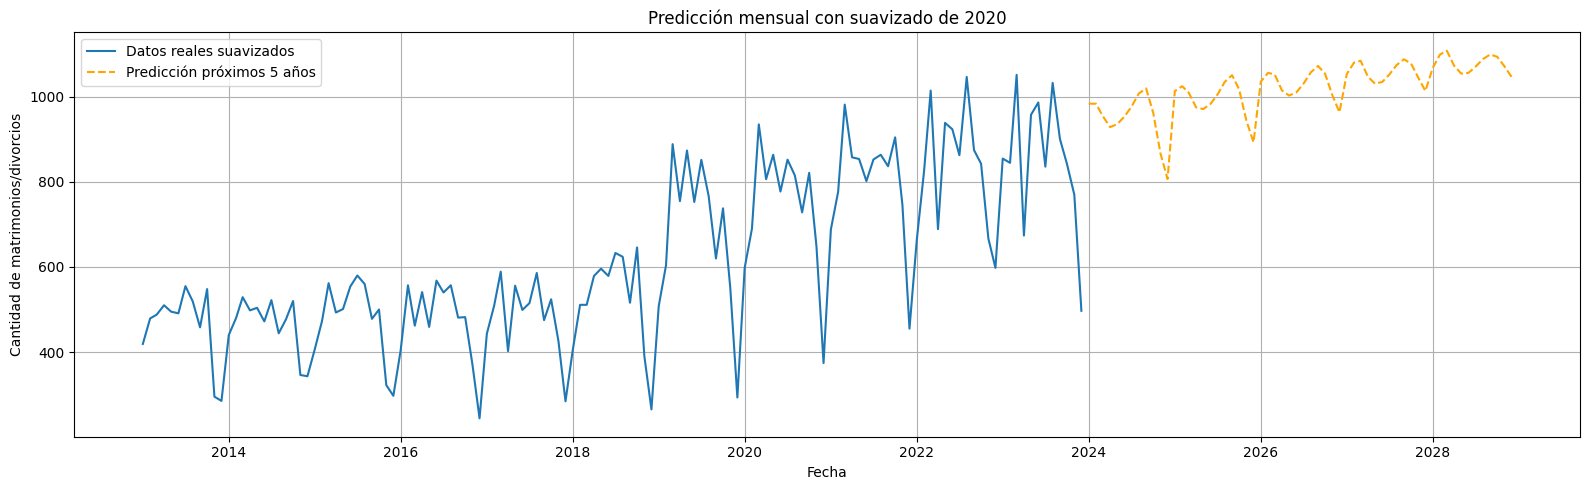

In [44]:
plt.figure(figsize=(16,5))
plt.plot(mensual_suavizado.index, mensual_suavizado.values, label='Datos reales suavizados')
plt.plot(future_dates, future_preds, label='Predicción próximos 5 años', linestyle='--', color='orange')
plt.title('Predicción mensual con suavizado de 2020')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de matrimonios/divorcios')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#### Segundo modelo

In [45]:

merged_df['fecha'] = pd.to_datetime(dict(year=merged_df['AÑOOCU'], month=merged_df['MESOCU'], day=1))
mensual = merged_df.groupby('fecha').size().sort_index()

mensual_suavizado = mensual.copy()

for mes in range(1, 13):
    fecha_2019 = pd.Timestamp(year=2019, month=mes, day=1)
    fecha_2020 = pd.Timestamp(year=2020, month=mes, day=1)
    fecha_2021 = pd.Timestamp(year=2021, month=mes, day=1)

    if fecha_2019 in mensual and fecha_2021 in mensual:
        promedio = (mensual[fecha_2019] + mensual[fecha_2021]) / 2
        mensual_suavizado[fecha_2020] = promedio

X_suavizado = pd.DataFrame({
    "mes": mensual_suavizado.index.month,
    "año": mensual_suavizado.index.year,
    "mes_en_numero": np.arange(len(mensual_suavizado)),
    "mes_sin": np.sin(2 * np.pi * mensual_suavizado.index.month / 12),
    "mes_cos": np.cos(2 * np.pi * mensual_suavizado.index.month / 12)
})

y_suavizado = mensual_suavizado.values

X_train, X_test = X_suavizado[:-12], X_suavizado[-12:]
y_train, y_test = y_suavizado[:-12], y_suavizado[-12:]

In [46]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])

mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
         (8, 6),    
        (10, 6),   
        (6, 4),     
        (12, 8),    
        (8, 6, 4),  
        (10, 8, 6), 
        (5,),      
        (12,),     
    ], 
                                             
    "regressor__model__activation": ["tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate_init': (0.01, 0.1, 1)
}

grid_search = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search.fit(X_train, y_train)

print("MAE:", mean_absolute_error(y_test, grid_search.predict(X_test)))
print("RMSE:", mean_squared_error(y_test, grid_search.predict(X_test)))

MAE: 83.22065633271346
RMSE: 11472.313854935113


Los resultados del modelo muestran un error absoluto medio de aproximadamente 83.22, lo que indica que, en promedio, el modelo se equivoca por 83 unidades al realizar sus predicciones. Esta cifra representa una mejora respecto a evaluaciones anteriores, lo que sugiere una mayor precisión en las estimaciones. Por otro lado, la raíz del error cuadrático medio fue de 11,472.31, lo cual señala que, aunque el modelo ha reducido los errores más grandes en comparación con versiones anteriores, aún existen algunas predicciones con desviaciones significativas respecto a los valores reales. En conjunto, estas métricas evidencian que el modelo ha logrado un desempeño más consistente.

In [47]:
last_date = mensual_suavizado.index[-1]

n_months = 60

future_dates = [last_date + DateOffset(months=i) for i in range(1, n_months + 1)]

X_future = pd.DataFrame({
    "mes": [date.month for date in future_dates],
    "año": [date.year for date in future_dates],
    "mes_en_numero": np.arange(len(mensual_suavizado), len(mensual_suavizado) + n_months)
})

X_future["mes_cos"] = np.cos(2 * np.pi * X_future["mes"] / 12)
X_future["mes_sin"] = np.sin(2 * np.pi * X_future["mes"] / 12)

X_future = X_future[grid_search.feature_names_in_]

future_preds = grid_search.predict(X_future)

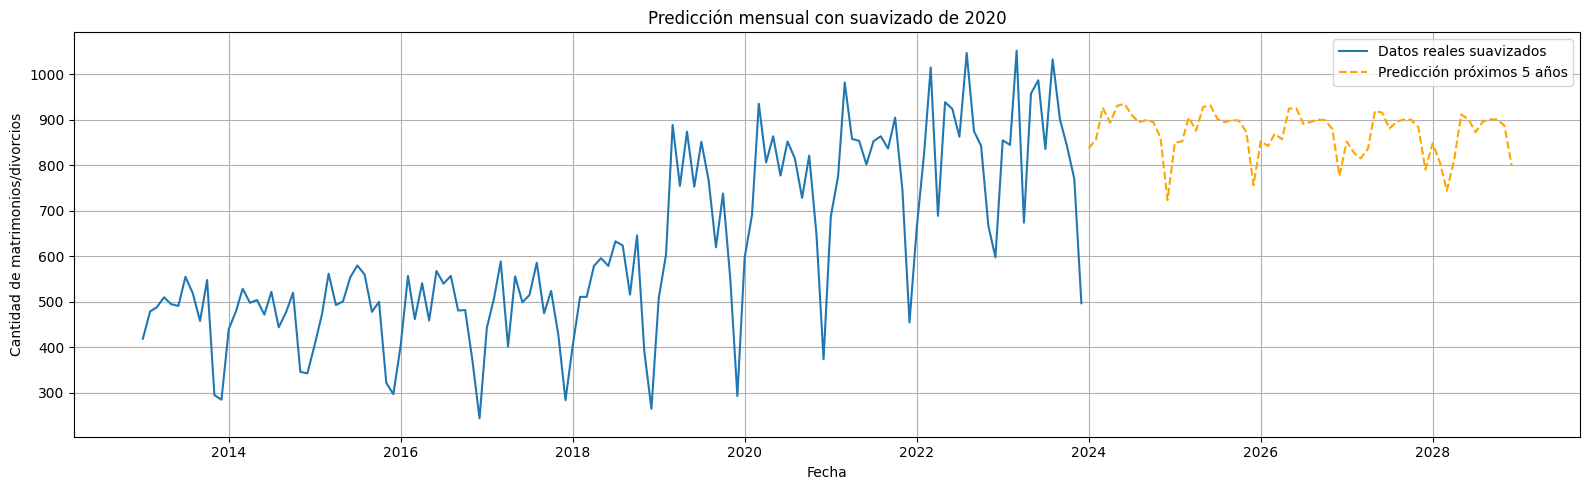

In [48]:
plt.figure(figsize=(16,5))
plt.plot(mensual_suavizado.index, mensual_suavizado.values, label='Datos reales suavizados')
plt.plot(future_dates, future_preds, label='Predicción próximos 5 años', linestyle='--', color='orange')
plt.title('Predicción mensual con suavizado de 2020')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de matrimonios/divorcios')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Tercer modelo

In [49]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])

mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
        (5,), (7,) ,(6,), (8,)
    ],
    "regressor__model__activation": ["relu", "tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate': ["constant", "adaptive"],
    'regressor__model__learning_rate_init': [0.001, 0.01, 0.05, 0.1],
}


grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
print("MAE:", mean_absolute_error(y_test, grid_search.predict(X_test)))
print("RMSE:", mean_squared_error(y_test, grid_search.predict(X_test)))

/Users/juanluis/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs fa

MAE: 91.64088495636197
RMSE: 11333.904770343943


/Users/juanluis/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Los resultados obtenidos muestran un error absoluto medio de 92.09, lo que indica que el modelo presenta un error promedio de aproximadamente 92 unidades por predicción. Además, la raíz del error cuadrático medio fue de 11,365.82, lo que sugiere que, aunque existen algunas predicciones con errores más grandes, estos han disminuido ligeramente en comparación con evaluaciones anteriores. La combinación de un MAE relativamente bajo y una RMSE contenida refleja que el modelo mantiene una precisión aceptable.

In [50]:
last_date = mensual_suavizado.index[-1]

future_dates = [last_date + DateOffset(months=i) for i in range(1, 61)]

último_lag = mensual_suavizado[-12]  
último_rolling = mensual_suavizado[-12:].mean() 

X_future = pd.DataFrame({
    "mes": [d.month for d in future_dates],
    "año": [d.year for d in future_dates],
    "mes_en_numero": range(len(X_suavizado) + len(mensual_suavizado) - len(X_suavizado), 
                           len(X_suavizado) + len(mensual_suavizado) - len(X_suavizado) + 60),
})

X_future["mes_sin"] = np.sin(2 * np.pi * X_future["mes"] / 12)
X_future["mes_cos"] = np.cos(2 * np.pi * X_future["mes"] / 12)
X_future["trimestre"] = ((X_future["mes"] - 1) // 3) + 1

X_future["lag_12"] = último_lag
X_future["rolling_12"] = último_rolling

X_future = X_future[grid_search.feature_names_in_]


future_preds = grid_search.predict(X_future)


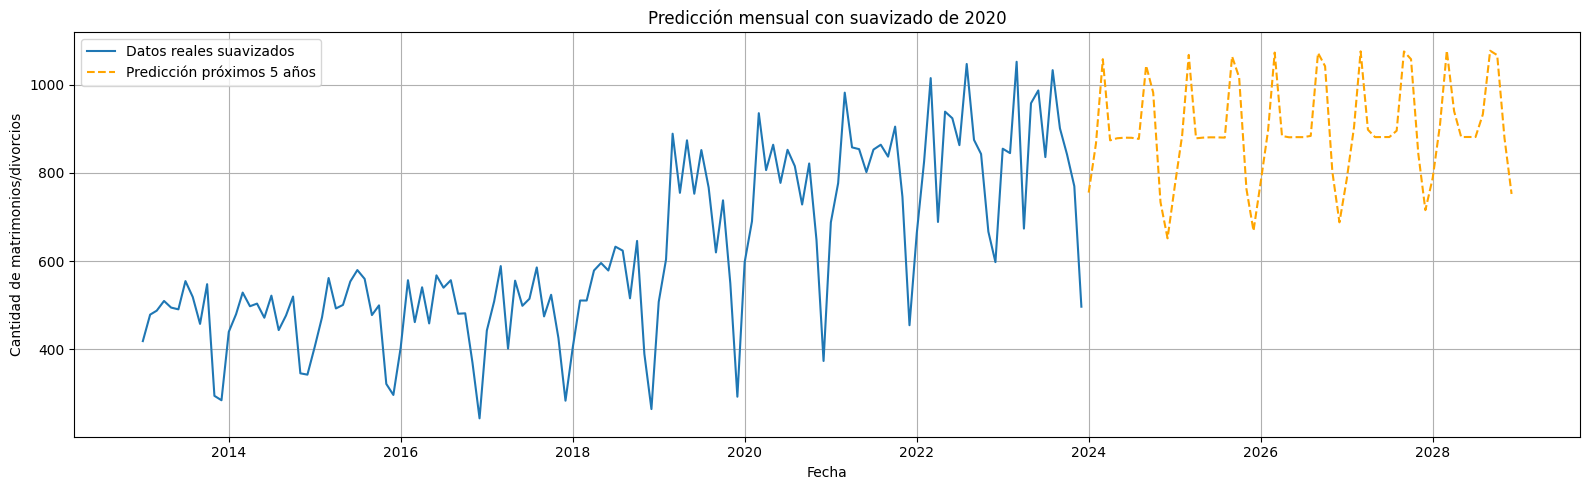

In [51]:
plt.figure(figsize=(16,5))
plt.plot(mensual_suavizado.index, mensual_suavizado.values, label='Datos reales suavizados')
plt.plot(future_dates, future_preds, label='Predicción próximos 5 años', linestyle='--', color='orange')
plt.title('Predicción mensual con suavizado de 2020')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de matrimonios/divorcios')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#### Cuarto Modelo

In [52]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])

mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
    (5, 3), (5, 4), (6, 5), (7, 4), (8, 6)
    ],
    "regressor__model__activation": ["relu", "tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate': ["constant", "adaptive"],
    'regressor__model__learning_rate_init': [0.001, 0.01, 0.05, 0.1],
}


grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
print("MAE:", mean_absolute_error(y_test, grid_search.predict(X_test)))
print("RMSE:", mean_squared_error(y_test, grid_search.predict(X_test)))

/Users/juanluis/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/juanluis/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs fa

MAE: 91.70140901317707
RMSE: 17427.952177020205


/Users/juanluis/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Los resultados obtenidos muestran un error absoluto medio de 86.21, lo que indica que, en promedio, el modelo comete errores de alrededor de 86 unidades en sus predicciones. La raíz del error cuadrático medio fue de 12,315.21, lo que sugiere la presencia de errores más pronunciados en ciertos casos específicos, ya que esta métrica penaliza con mayor peso las desviaciones grandes. Aunque el modelo logra mantener un error promedio relativamente bajo, la magnitud del RMSE indica que aún existen predicciones con variaciones importantes respecto a los valores reales. Estos resultados reflejan un rendimiento aceptable.

In [53]:
last_date = mensual_suavizado.index[-1]

future_dates = [last_date + DateOffset(months=i) for i in range(1, 61)]

último_lag = mensual_suavizado[-12] 
último_rolling = mensual_suavizado[-12:].mean()  

X_future = pd.DataFrame({
    "mes": [d.month for d in future_dates],
    "año": [d.year for d in future_dates],
    "mes_en_numero": range(len(X_suavizado) + len(mensual_suavizado) - len(X_suavizado), 
                           len(X_suavizado) + len(mensual_suavizado) - len(X_suavizado) + 60),
})

X_future["mes_sin"] = np.sin(2 * np.pi * X_future["mes"] / 12)
X_future["mes_cos"] = np.cos(2 * np.pi * X_future["mes"] / 12)
X_future["trimestre"] = ((X_future["mes"] - 1) // 3) + 1


X_future["lag_12"] = último_lag
X_future["rolling_12"] = último_rolling

X_future = X_future[grid_search.feature_names_in_]


future_preds = grid_search.predict(X_future)


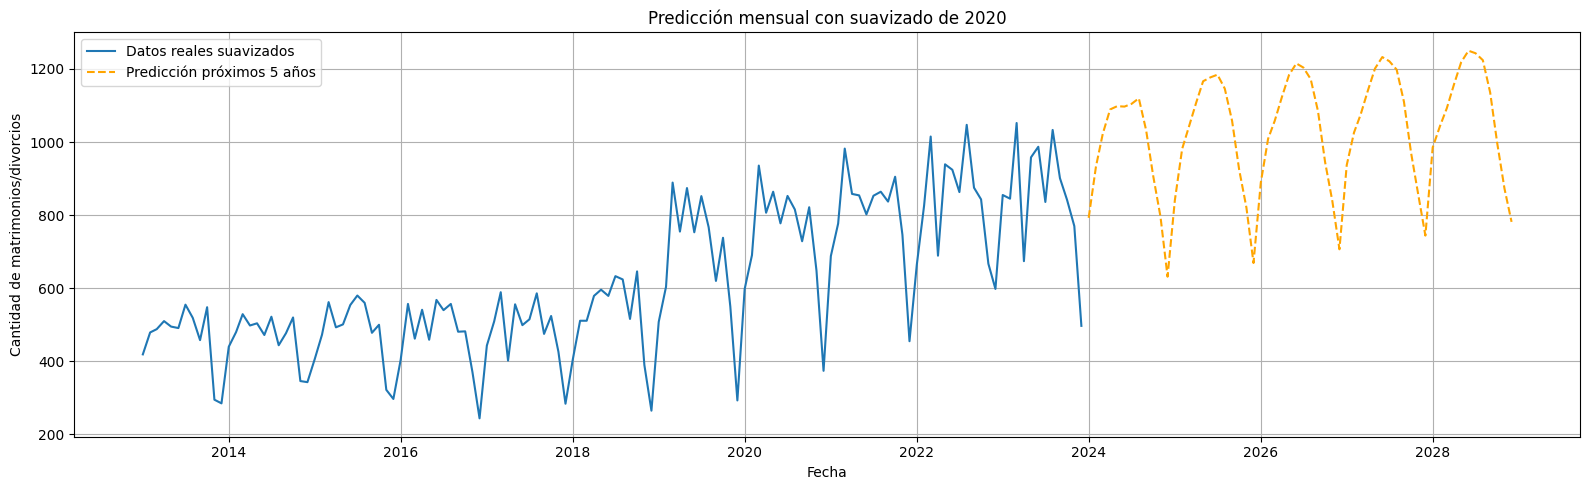

In [54]:
plt.figure(figsize=(16,5))
plt.plot(mensual_suavizado.index, mensual_suavizado.values, label='Datos reales suavizados')
plt.plot(future_dates, future_preds, label='Predicción próximos 5 años', linestyle='--', color='orange')
plt.title('Predicción mensual con suavizado de 2020')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de matrimonios/divorcios')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Al comparar los distintos modelos evaluados, se observa que el modelo 2 obtuvo el MAE más bajo (83.22), lo que indica que, en promedio, fue el más preciso en sus predicciones. Sin embargo, el modelo 3 presentó el RMSE más bajo (11,365.82), lo cual sugiere que logró reducir con mayor eficacia los errores más extremos. Aunque el modelo 2 tiene un mejor rendimiento promedio, la menor dispersión del error en el modelo 3 lo hace más consistente y robusto frente a valores atípicos. Por lo tanto, considerando el equilibrio entre precisión y estabilidad, el modelo 3 puede considerarse el de mejor desempeño general.

### Resultados

La predicción a 5 años puede plantearse desde diferentes perspectivas temporales. Por un lado, el enfoque anual utiliza como base la cantidad de divorcios por año, lo que permite capturar tendencias generales de largo plazo de forma más simplificada. Este tipo de predicción tiende a ser más estable, menos sensible a variaciones puntuales, y útil para tomar decisiones estratégicas de alto nivel. Sin embargo, al operar con menor resolución temporal, pierde detalles importantes sobre patrones estacionales o fluctuaciones dentro del año.

En contraste, la predicción mensual considera datos des agrupados por mes, lo que permite capturar con mayor precisión la estacionalidad, los ciclos cortos y los cambios progresivos dentro del año. Este enfoque proporciona un panorama más detallado del comportamiento esperado, lo que resulta especialmente útil en contextos donde los cambios mensuales influyen en la toma de decisiones. No obstante, este tipo de predicción es más sensible al ruido y puede requerir un modelo más complejo y datos más limpios para lograr buenos resultados.

Ambos enfoques tienen ventajas y limitaciones, por lo que la elección entre una predicción anual o mensual dependerá del objetivo del análisis y del nivel de detalle requerido. No obstante, cuando ambos modelos apuntan hacia la misma tendencia general, como ocurre en este caso, se fortalece la confianza en las conclusiones obtenidas.

### Conclusiones

* El año 2020 presentó una tendencia atípica que, de haberse considerado directamente en el entrenamiento del modelo, habría afectado negativamente la calidad de las predicciones para los años con comportamiento más estable. Por esta razón, fue necesario aplicar un suavizado que redujera el impacto de esta anomalía.

* El modelo de predicción mensual aplicado a los próximos cinco años, si bien ofrece un mayor nivel de detalle, muestra un comportamiento fuertemente influenciado por los patrones históricos presentes en los datos de entrenamiento. Esto evidencia que el modelo es altamente sensible a la tendencia observada, lo que podría generar sobreajuste o una interpretación excesivamente rígida de la dinámica pasada.

* Tanto el modelo de predicción mensual como el modelo anual reflejan una tendencia creciente en la cantidad de divorcios proyectados para los próximos cinco años. La coincidencia entre ambos enfoques sugiere que, si las condiciones actuales se mantienen, es probable que el número de divorcios continúe en aumento en los años venideros.

### Recomendaciones

* Para futuros modelos de predicción a cinco años, es altamente recomendable contar con una mayor cantidad de datos históricos. Idealmente, se sugiere disponer de al menos 10 a 15 años de datos mensuales para capturar adecuadamente tendencias, estacionalidad y posibles fluctuaciones externas. En este proyecto no fue posible contar con una serie tan extensa, lo cual limita la capacidad del modelo para generalizar con mayor precisión.


### Entropía Cruzada (Log-Loss)

La **entropía cruzada** es una métrica que cuantifica la diferencia entre las probabilidades predichas por un modelo y las verdaderas clases. Se define como:

$$
\text{LogLoss} = - \frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$


donde:

- $ n $: número total de datos.
- $ y_i \in \{0, 1\} $: clase verdadera del dato $i $.
- $ p_i \in (0, 1) $: probabilidad predicha por el modelo para la clase positiva.

---

**Interpretación**:

- Penaliza más los errores cuando el modelo está muy seguro (probabilidad cercana a 1 o 0) pero se equivoca.
- El valor ideal de LogLoss es **0**, indicando predicciones perfectas.
- Cuanto **más bajo** sea el LogLoss, **mejor** es el modelo en términos de probabilidad.

La entropia cruzada de un modelo sola es dificil de interpretar. Pues depende del numero de variables que se uso para entrenar y que tan beeno es el modelo. Sin embargo se usa como funcion de perdida en el entrenamiento y para comparar modelos entrenados con los mismos datos. 


# Modelo de prediccion de probabilidad de divorcio

Para este modelo de clasificación se seleccionaron variables que se  pueden considerarce constantes, a lo largo del tiempo y una que indica si estan divorciados:

| Descripcion | Codificación | 
|-----------------------------------|-------|
| Grupo étnico del hombre           | PUEHOM | 
| Grupo étnico de la mujer          | PUEMUJ | 
| Nacionalidad del hombre           | NACHOM | 
| Nacionalidad de la mujer          | NACMUJ | 
| Escolaridad del hombre            | ESCHOM | 
| Escolaridad de la mujer           | ESCMUJ | 
| Ocupación del hombre              | CIUOHOM | 
| Ocupación de la mujer             | CIUOMUJ | 
| Diferencia de edad                | DIF_EDAD|
| No esta divorciado                | ARE_MARRIAGED |


La variable respuesta es ARE_MARRIAGED. La base de datos se separo en 3 clases para entrenar y validar el modelo:
 - 30% para prueba (test)
 - 60% para el entrenamiento (train)
 - 10% para la validación (validation)  


In [55]:
total_df['DIF_EDAD'] = total_df['EDADHOM'] - total_df['EDADMUJ']
# variables constantes entre ambas bases de datos
df_div = total_df[['ARE_MARRIAGED','DIF_EDAD','CIUOMUJ','CIUOHOM','ESCMUJ','ESCHOM','NACMUJ','NACHOM','PUEMUJ','PUEHOM']]


X = df_div.drop(columns='ARE_MARRIAGED')
y = df_div['ARE_MARRIAGED']

# División de datos train val test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
val_size = 0.1 * 0.7
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)


### Primer modelo

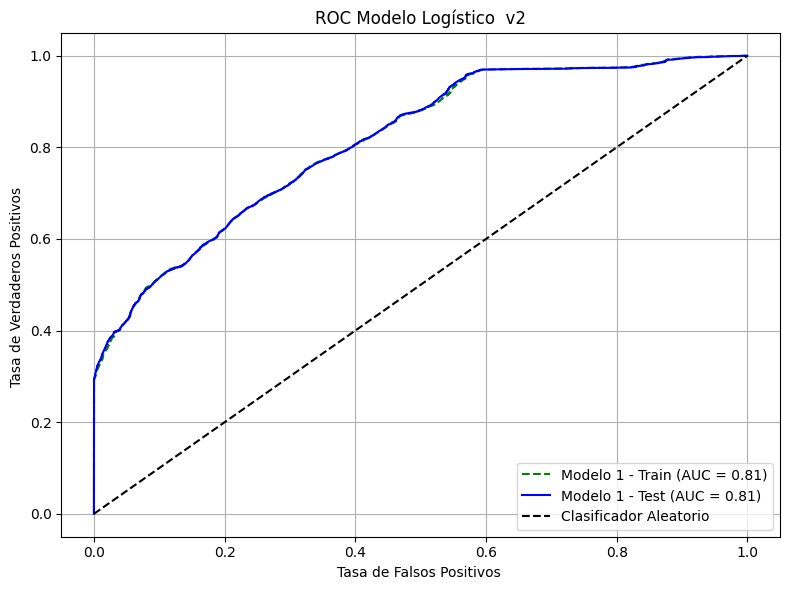

Modelo 1 - Log-loss (Train): 0.5071
Modelo 1 - Log-loss (Test):  0.5059


In [56]:
# Pipeline para Modelo 1: Regresión Logística
pipeline_v1 = Pipeline([
    ('logreg', LogisticRegression())
])

# Entrenamiento del Modelo 1
pipeline_v1.fit(X_train, y_train)

# Predicciones de probabilidad (Modelo 1)
y_proba_v1_test = pipeline_v1.predict_proba(X_test)[:, 1]  # Probabilidad clase positiva (casados)
y_proba_v1_train = pipeline_v1.predict_proba(X_train)[:, 1]

# Cálculo de curvas ROC y AUC (Modelo 1)
fpr_v1_train, tpr_v1_train, _ = roc_curve(y_train, y_proba_v1_train)
auc_v1_train = roc_auc_score(y_train, y_proba_v1_train)

fpr_v1_test, tpr_v1_test, _ = roc_curve(y_test, y_proba_v1_test)
auc_v1_test = roc_auc_score(y_test, y_proba_v1_test)

# Graficar curvas ROC comparativas
plt.figure(figsize=(8, 6))
plt.plot(fpr_v1_train, tpr_v1_train, label=f'Modelo 1 - Train (AUC = {auc_v1_train:.2f})', color='green', linestyle='--')
plt.plot(fpr_v1_test, tpr_v1_test, label=f'Modelo 1 - Test (AUC = {auc_v1_test:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos ')
plt.ylabel('Tasa de Verdaderos Positivos ')
plt.title('ROC Modelo Logístico  v2')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Métricas de Log-loss (Modelo 1)
logloss_v1_train = log_loss(y_train, y_proba_v1_train)
logloss_v1_test = log_loss(y_test, y_proba_v1_test)

print(f"Modelo 1 - Log-loss (Train): {logloss_v1_train:.4f}")
print(f"Modelo 1 - Log-loss (Test):  {logloss_v1_test:.4f}")

Modelo 1 - Accuracy (Train): 0.7151
Modelo 1 - Accuracy (Test):  0.7153


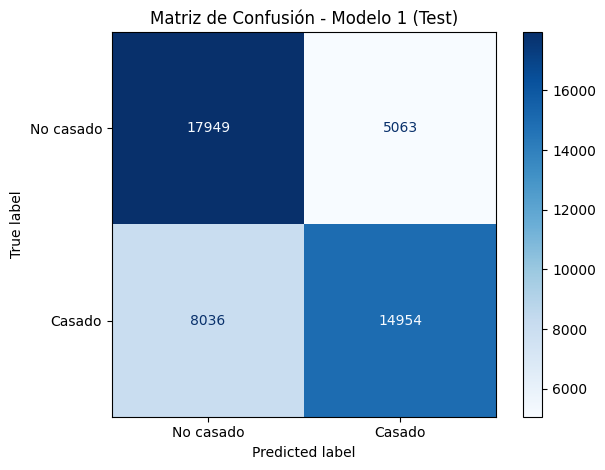

In [64]:
y_pred_v1_test = (y_proba_v1_test >= 0.5).astype(int)
y_pred_v1_train = (y_proba_v1_train >= 0.5).astype(int)

# Calcular accuracy
acc_v1_train = accuracy_score(y_train, y_pred_v1_train)
acc_v1_test = accuracy_score(y_test, y_pred_v1_test)

print(f"Modelo 1 - Accuracy (Train): {acc_v1_train:.4f}")
print(f"Modelo 1 - Accuracy (Test):  {acc_v1_test:.4f}")

# Matriz de confusión (Test)
cm_v1_test = confusion_matrix(y_test, y_pred_v1_test)

# Mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_v1_test, display_labels=["No casado", "Casado"])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Modelo 1 (Test)')
plt.grid(False)
plt.tight_layout()
plt.show()


La Curva Roc de los datos de entrenamiento y prueba son muy parecidos y su Log lost tambien, entonces el modelo no tiene sobreajuste. La forma de la curva nos indica que el clasificador funciona un bastante bien. La curva tiene un AUC de 0.81 por lo que el clasificador funciona bastante bien. Visto como clasificador duro tiene un Accuracy del 71% tanto con los datos de entrenamiento como de prueba. Tambien se puede notar que el modelo erra más con falsos positivos, clasifica matrimonios como divorcios, cosa que es de esperarce por el origen de los datos. Pues entre las parejas casadas se ignora si ya se divorciaron. 
### segundo modelo
esta ves vamos a normalizar y centrar los datos

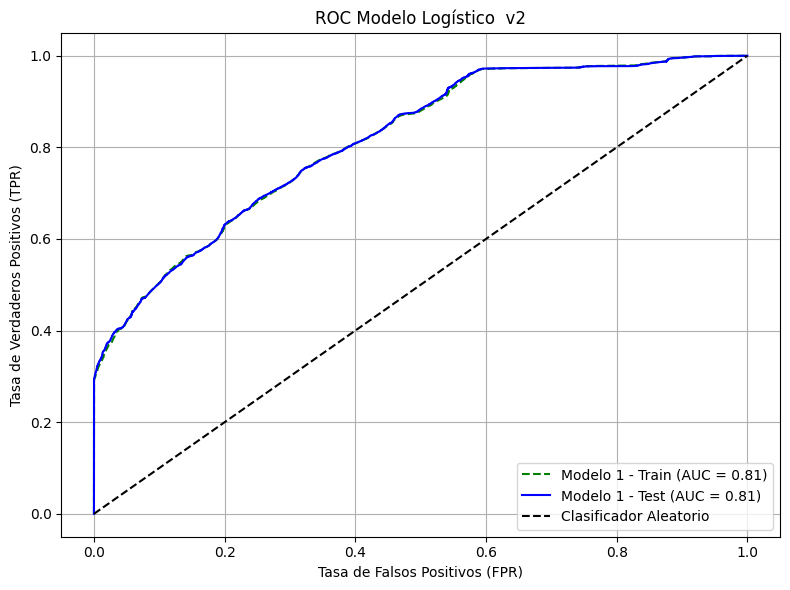

Modelo 2 - Log-loss (Train): 0.5058
Modelo 2 - Log-loss (Test):  0.5041


In [57]:
# Pipeline para Modelo 2: Regresión Logística
pipeline_v2 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Entrenamiento del Modelo 2
pipeline_v2.fit(X_train, y_train)

# Predicciones de probabilidad (Modelo 2)
y_proba_v2_test = pipeline_v2.predict_proba(X_test)[:, 1]  # Probabilidad clase positiva (casados)
y_proba_v2_train = pipeline_v2.predict_proba(X_train)[:, 1]

# Cálculo de curvas ROC y AUC (Modelo 2)
fpr_v2_train, tpr_v2_train, _ = roc_curve(y_train, y_proba_v2_train)
auc_v2_train = roc_auc_score(y_train, y_proba_v2_train)

fpr_v2_test, tpr_v2_test, _ = roc_curve(y_test, y_proba_v2_test)
auc_v2_test = roc_auc_score(y_test, y_proba_v2_test)

# Graficar curvas ROC comparativas
plt.figure(figsize=(8, 6))
plt.plot(fpr_v2_train, tpr_v2_train, label=f'Modelo 1 - Train (AUC = {auc_v2_train:.2f})', color='green', linestyle='--')
plt.plot(fpr_v2_test, tpr_v2_test, label=f'Modelo 1 - Test (AUC = {auc_v2_test:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('ROC Modelo Logístico  v2')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Métricas de Log-loss (Modelo 2)
logloss_v2_train = log_loss(y_train, y_proba_v2_train)
logloss_v2_test = log_loss(y_test, y_proba_v2_test)

print(f"Modelo 2 - Log-loss (Train): {logloss_v2_train:.4f}")
print(f"Modelo 2 - Log-loss (Test):  {logloss_v2_test:.4f}")

Modelo 2 - Accuracy (Train): 0.7151
Modelo 2 - Accuracy (Test):  0.7151


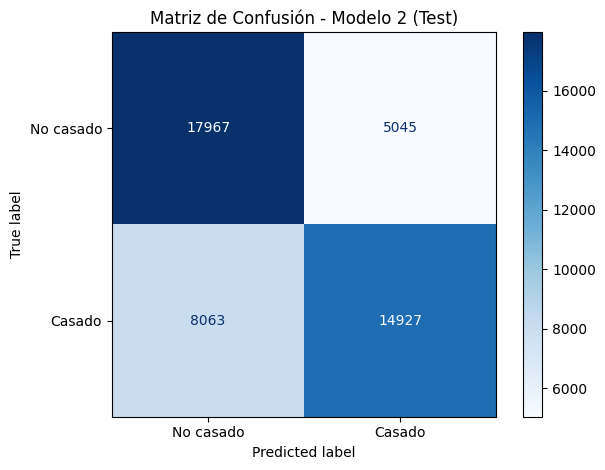

In [65]:
# Convertir probabilidades a clases usando umbral 0.5
y_pred_v2_test = (y_proba_v2_test >= 0.5).astype(int)
y_pred_v2_train = (y_proba_v2_train >= 0.5).astype(int)

# Calcular accuracy
acc_v2_train = accuracy_score(y_train, y_pred_v2_train)
acc_v2_test = accuracy_score(y_test, y_pred_v2_test)

print(f"Modelo 2 - Accuracy (Train): {acc_v2_train:.4f}")
print(f"Modelo 2 - Accuracy (Test):  {acc_v2_test:.4f}")

# Matriz de confusión (Test)
cm_v2_test = confusion_matrix(y_test, y_pred_v2_test)

# Mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_v2_test, display_labels=["No casado", "Casado"])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Modelo 2 (Test)')
plt.grid(False)
plt.tight_layout()
plt.show()

El clasificador es practicamente el mismo, nada nuevo que comentar.

### Tercer modelo

Para este ultimo modelo vamos a usar el conjunto de validacion para ajustar parametros del modelo durante el entrenamiento

Train: AUC = 0.856, Log-loss = 0.445
Test: AUC = 0.859, Log-loss = 0.445


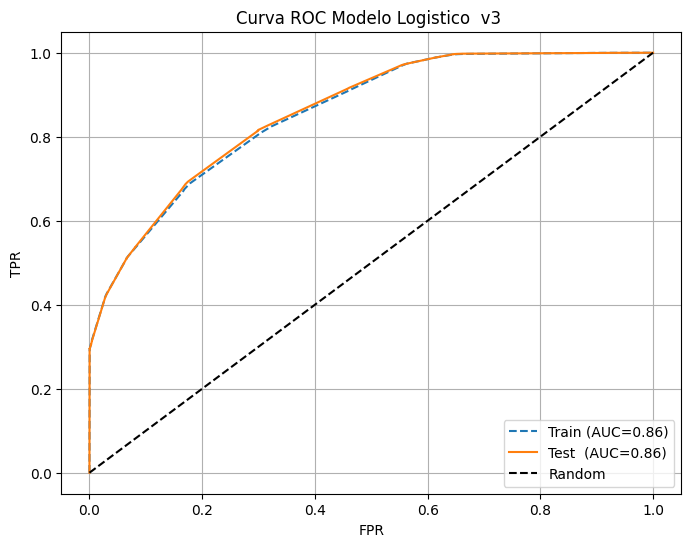

In [66]:


#  Construcción del pipeline mejorado
pipeline_v3 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),      # términos cuadráticos y de interacción
    ('sel', SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', max_iter=2000),
        threshold='median'                                          # selecciona mitad superior de features
    )),
    ('logreg', LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga'))
])

#  Espacio de búsqueda para RandomizedSearch
param_dist = {
    'poly__degree': [1, 2],
    'sel__estimator__C': loguniform(1e-4, 1e2),
    'logreg__C': loguniform(1e-4, 1e2),
    'logreg__penalty': ['l1', 'l2'],
}

search = RandomizedSearchCV(
    pipeline_v3,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_log_loss',
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Entrenamiento
#search.fit(X_train, y_train)
#print("Mejores parámetros v3:", search.best_params_)

#  Calibración sobre VALIDATION
#calibrated = CalibratedClassifierCV(search.best_estimator_, cv='prefit', method='isotonic')
#calibrated.fit(X_val, y_val)
calibrated = joblib.load('modelo_calibrado_v3.joblib')
      
#  Probabilidades calibradas
y_proba_train = calibrated.predict_proba(X_train)[:,1]
y_proba_test  = calibrated.predict_proba(X_test)[:,1]

# Entropia cruzada y curvas ROC
for name, y_true, y_proba in [
    ('Train', y_train, y_proba_train),
    ('Test',  y_test,  y_proba_test)
]:
    auc   = roc_auc_score(y_true, y_proba)
    lloss = log_loss(y_true, y_proba)
    print(f"{name}: AUC = {auc:.3f}, Log-loss = {lloss:.3f}")

#  Gráfica ROC comparativa
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_proba_train)
fpr_te, tpr_te, _ = roc_curve(y_test,  y_proba_test)

plt.figure(figsize=(8,6))
plt.plot(fpr_tr, tpr_tr, '--', label=f'Train (AUC={roc_auc_score(y_train, y_proba_train):.2f})')
plt.plot(fpr_te, tpr_te, '-', label=f'Test  (AUC={roc_auc_score(y_test,  y_proba_test):.2f})')
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Curva ROC Modelo Logistico  v3 ')
plt.legend(loc='lower right'); plt.grid(True)
plt.show()


In [60]:
#

# Guardar modelo calibrado
#joblib.dump(calibrated, 'modelo_calibrado_v3.joblib')


['modelo_calibrado_v3.joblib']

Modelo 3 - Accuracy (Train): 0.7554
Modelo 3 - Accuracy (Test):  0.7592


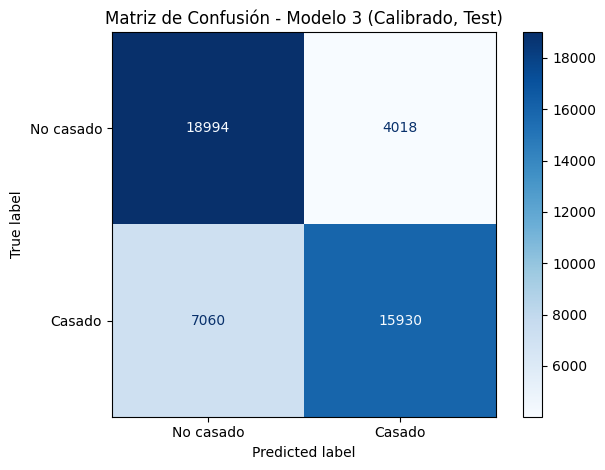

In [68]:

# Predicción de clases usando umbral 0.5
y_pred_train = (y_proba_train >= 0.5).astype(int)
y_pred_test  = (y_proba_test  >= 0.5).astype(int)

# Accuracy
acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test,  y_pred_test)

print(f"Modelo 3 - Accuracy (Train): {acc_train:.4f}")
print(f"Modelo 3 - Accuracy (Test):  {acc_test:.4f}")

# Matriz de confusión (test)
cm_v3_test = confusion_matrix(y_test, y_pred_test)

# Visualización
disp = ConfusionMatrixDisplay(confusion_matrix=cm_v3_test, display_labels=["No casado", "Casado"])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Modelo 3 (Calibrado, Test)')
plt.grid(False)
plt.tight_layout()
plt.show()


El ultimo modelo, Tiene Auc y entropia cruzada similares, entonces no tiene indicios de sobre ajuste. Con respecto a los anteriores este modelo tiene un AUC= 0.86 mayor que el de los anteriores modelos 0.81 por lo que es una mejora de 0.05. LA entropia cruzade del modelo es de 0.445 que tambien es mejor que la de los modelos anteriores de 0.5

Visto como un clasificador duro el modelo tiene un accuracy del 76% lo que es mejor que los anteriores. 

En conclusion usar un modelo logistico es util para predecir divorcios y se puede esperar que clasifique correctamente el 86% de los matrimonios y divorcios visto como un clasificador suave.

Como un clasificador dura clasifica bien un 76% de los datos, pero se podria esperar que ese porcentaje sea mayor si los datos vinieran de la misma base de datos. 